## Explore change point detection by different algorithms

In [1]:
# imports
from utils import helpers, constants
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

## EMD

In [2]:

# config
change_point_detector = 'emd'

# load data dictionary
data_dictionary = helpers.load_data_dictionary(constants.DATA_DICTIONARY_FILE_PATH)

In [ ]:
from collections import defaultdict


window_sizes = [100, 200, 300, 400, 500, 600]

# Load all change points into a consistent dictionary of DataFrames
change_points_dict = {}

for dataset in data_dictionary:
    dataset_cps = defaultdict(list)  # maps window_size → list of change points

    for window_size in window_sizes:
        results_path = f'results/drift_detection/{dataset}/results_{dataset}_{change_point_detector}{window_size}.csv'

        if os.path.exists(results_path):
            results_df = pd.read_csv(results_path)

            for _, row in results_df.iterrows():
                if row.get('calc_drift_id') == 'na':
                    break

                change_point = row.get('calc_change_index')
                
                if pd.notna(change_point):
                    dataset_cps[window_size].append(int(change_point))

    # convert defaultdict to normal dict before storing
    change_points_dict[dataset] = dict(dataset_cps)

<Figure size 1000x600 with 0 Axes>

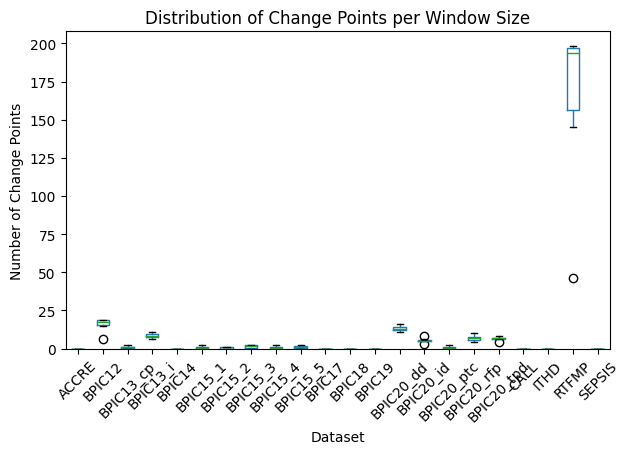

In [4]:
#show boxplot of change point counts per dataset and window setting

# Flatten to a list of (dataset, number of change points per window-size entry)
data = []
for dataset, window_dict in change_points_dict.items():
    for window_size in window_sizes:
        cps = window_dict.get(window_size, [])
        data.append((dataset, window_size, len(cps)))

# Create DataFrame for plotting
df = pd.DataFrame(data, columns=["Dataset", "Window_Size", "NumChangePoints"])

# Create boxplot
plt.figure(figsize=(10, 6))
df.boxplot(column="NumChangePoints", by="Dataset", grid=False)
plt.title("Distribution of Change Points per Window Size")
plt.suptitle("")  # Remove automatic matplotlib title
plt.xlabel("Dataset")
plt.ylabel("Number of Change Points")
plt.ylim(bottom=0)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

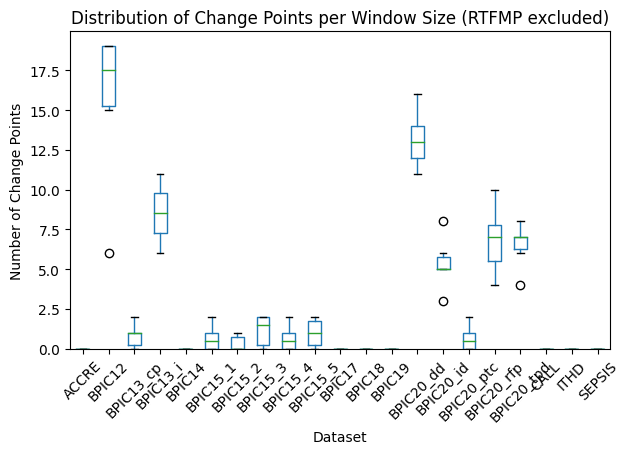

In [5]:
# Filter out RTFMP and recreate the boxplot
df_no_rtfmp = df[df["Dataset"] != "RTFMP"]

plt.figure(figsize=(10, 6))
df_no_rtfmp.boxplot(column="NumChangePoints", by="Dataset", grid=False)
plt.title("Distribution of Change Points per Window Size (RTFMP excluded)")
plt.suptitle("")
plt.xlabel("Dataset")
plt.ylabel("Number of Change Points")
plt.ylim(bottom=0)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [6]:
# Summarize relevant change count statistics per dataset
summary_df = df.groupby("Dataset")["NumChangePoints"].agg(
    min_change_points="min",
    max_change_points="max",
    mean_change_points="mean",
    median_change_points="median",
    std_change_points="std",
).reset_index()
summary_df

,Dataset,min_change_points,max_change_points,mean_change_points,median_change_points,std_change_points
0,ACCRE,0,0,0.000000,0.0,0.000000
1,BPIC12,6,19,15.666667,17.5,5.046451
2,BPIC13_cp,0,2,0.833333,1.0,0.752773
3,BPIC13_i,6,11,8.500000,8.5,1.870829
4,BPIC14,0,0,0.000000,0.0,0.000000
5,BPIC15_1,0,2,0.666667,0.5,0.816497
6,BPIC15_2,0,1,0.333333,0.0,0.516398
7,BPIC15_3,0,2,1.166667,1.5,0.983192
8,BPIC15_4,0,2,0.666667,0.5,0.816497
9,BPIC15_5,0,2,1.000000,1.0,0.894427


In [7]:

def aggregate_change_points_by_window(cp_all_window_sizes, alpha=1.0):
    """
    Aggregates change points across window sizes by merging close ones,
    preferring the closest match (not just the first found).

    Returns a DataFrame with cp, window_size, support.
    """
    if not cp_all_window_sizes:
        return pd.DataFrame(columns=["cp", "window_size", "support", "supporting_windows"])

    max_ws = max(cp_all_window_sizes.keys())

    # Step 1: Flatten and initialize support + support set
    records = []
    for ws, cp_list in cp_all_window_sizes.items():
        for cp in cp_list:
            support = 1
            records.append({
                "cp": cp,
                "window_size": ws,
                "support": support,
                "supporting_windows": {ws}
            })

    # Sort by descending window size, then cp
    records.sort(key=lambda x: (-x["window_size"], x["cp"]))

    merged_records = []

    for i, rec_a in enumerate(records):
        candidates = []

        # Find merge candidates in smaller window sizes
        for j in range(i + 1, len(records)):
            rec_b = records[j]
            if rec_b["window_size"] >= rec_a["window_size"]:
                continue  # only merge into smaller window

            dist = abs(rec_a["cp"] - rec_b["cp"])
            if dist <= rec_a["window_size"] * alpha:
                candidates.append((dist, rec_b))

        # Choose the closest candidate (if any)
        if candidates:
            _, closest = min(candidates, key=lambda x: x[0])
            closest["support"] += rec_a["support"]
            closest["supporting_windows"] |= rec_a["supporting_windows"]
        else:
            merged_records.append(rec_a)

    return pd.DataFrame(merged_records)

# --- Outer filtering function --- #

def deduplicate_change_points_by_window(cp_all_window_sizes, alpha=1.0, min_support_windows=3):
    """
    Deduplicate change points by support-based filtering on top of aggregation.

    Parameters
    ----------
    cp_em_all_window_sizes : dict
        Dictionary of form {window_size: [change_point_1, ...]}
    alpha : float
        Distance factor for merging similar change points
    min_support_windows : int
        Min number of windows supporting the change point.

    Returns
    -------
    list of int
        Deduplicated and filtered list of change points
    """
    if not cp_all_window_sizes:
        return []


    # Aggregate and merge support
    aggregated_df = aggregate_change_points_by_window(cp_all_window_sizes, alpha)

    # handle no change point situations
    if aggregated_df.empty:
        return []
  
    # Filter per threshold
    filtered_df = aggregated_df[aggregated_df["support"] >= min_support_windows]

    return list(filtered_df["cp"])

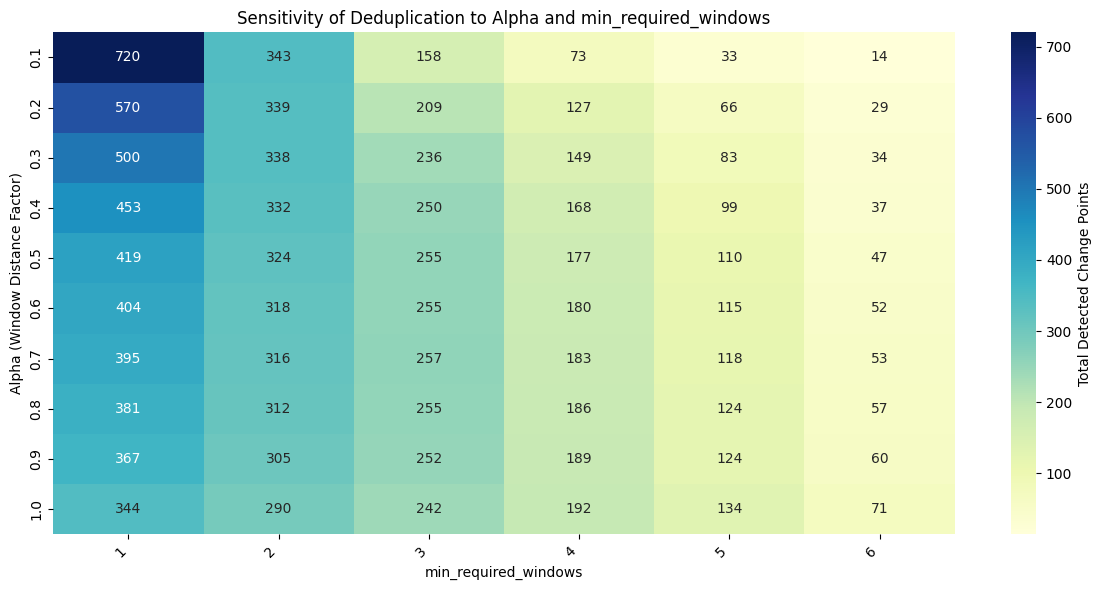

In [8]:
# check sensitivity of input parmeters

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Define parameters
alphas = np.round(np.arange(0.1, 1.01, 0.1), 2)
min_support_windows_list = [1, 2, 3, 4, 5, 6]

# Optional: label each window set for x-axis
window_labels = [str(ws) for ws in min_support_windows_list]

# Initialize heatmap data: rows = alphas, columns = window_sets
heatmap_data = pd.DataFrame(index=alphas, columns=window_labels)

# Loop over all combinations
for alpha in alphas:
    for i, min_support_windows in enumerate(min_support_windows_list):
        label = window_labels[i]
        total_cps = 0

        for dataset, cp_all_window_sizes in change_points_dict.items():
            cps = deduplicate_change_points_by_window(
                cp_all_window_sizes,
                alpha=alpha,
                min_support_windows=min_support_windows
            )
            total_cps += len(cps)

        heatmap_data.at[alpha, label] = total_cps

# Convert to numeric for plotting
heatmap_data = heatmap_data.astype(int)

# Plot
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="YlGnBu", cbar_kws={'label': 'Total Detected Change Points'})
plt.title("Sensitivity of Deduplication to Alpha and min_required_windows")
plt.xlabel("min_required_windows")
plt.ylabel("Alpha (Window Distance Factor)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [9]:
# 1. Aggregate all datasets (returns DataFrames)
aggregated_cp_dict = {
    dataset: aggregate_change_points_by_window(cp_all_window_sizes, alpha=0.5)
    for dataset, cp_all_window_sizes in change_points_dict.items()
}

# 2. Deduplicate all datasets (returns lists of CPs)
deduplicated_cp_dict = {
    dataset: deduplicate_change_points_by_window(cp_all_window_sizes, alpha=0.5, min_support_windows=3)
    for dataset, cp_all_window_sizes in change_points_dict.items()
}

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
from pandas.api.types import is_numeric_dtype

def plot_change_points(dataset, input, input_type, config_column_in_df=None, y_axis_label=None,
                       configuration_labels=None, default_configuration=None, title_suffix=""):
    # --- Normalize input to DataFrame ---
    if input_type == 'list_of_configurations':
        label_name = y_axis_label or "Configuration"
        rows = [{"cp": cp, label_name: label} for label, cps in input.items() for cp in cps]
        dataset_df = pd.DataFrame(rows)
    elif input_type == 'list_of_cps':
        dataset_df = pd.DataFrame({"cp": input})
    elif input_type == 'dataframe':
        dataset_df = input.copy()
    else:
        raise ValueError("input_type must be 'list_of_configurations', 'list_of_cps', or 'dataframe'")

    if dataset_df.empty:
        print(f"[INFO] No change points to plot for dataset {dataset}.")
        return

    plt.figure(figsize=(10, 6))

    # Determine y column
    y_col = (config_column_in_df if (config_column_in_df and config_column_in_df in dataset_df.columns)
             else (y_axis_label if (y_axis_label and y_axis_label in dataset_df.columns) else None))

    # Optional size mapping
    use_size = "support" in dataset_df.columns
    if use_size:
        smin, smax = float(dataset_df["support"].min()), float(dataset_df["support"].max())
        dataset_df["point_size"] = 100.0 if smax == smin else np.interp(dataset_df["support"], [smin, smax], [50, 200])

    # Numeric or categorical?
    y_is_numeric = (y_col is not None) and is_numeric_dtype(dataset_df[y_col])

    # If categorical y: enforce full category list so empty ones can be shown
    if (y_col is not None) and (configuration_labels is not None) and (not y_is_numeric):
        dataset_df[y_col] = pd.Categorical(dataset_df[y_col], categories=configuration_labels, ordered=True)

    # --- Helper to draw points ---
    def _scatter(df, color, z=2):
        sns.scatterplot(
            data=df, x="cp", y=(y_col if y_col else 0),
            size=("point_size" if use_size else None),
            sizes=(50, 200) if use_size else None,
            legend=False, color=color, zorder=z
        )

    # Plot others first, default on top
    if default_configuration and (y_col in dataset_df.columns):
        mask = dataset_df[y_col].astype(str) == str(default_configuration)
        _scatter(dataset_df[~mask], "blue", z=2)
        _scatter(dataset_df[mask],   "red",  z=3)
    else:
        _scatter(dataset_df, "blue", z=2)

    # --- Labels, ticks, limits ---
    plt.title(f"Detected Change Points for {dataset}{' - ' + title_suffix if title_suffix else ''}")
    plt.xlabel("Trace Index")

    ax = plt.gca()
    if input_type != 'list_of_cps':
        plt.ylabel(y_axis_label if y_axis_label else (y_col if y_col else ""))

        if configuration_labels is not None:
            if y_is_numeric:
                # Numeric: force ticks & limits so empty labels show
                ax.set_yticks(configuration_labels)
                ymin, ymax = min(configuration_labels), max(configuration_labels)
                pad = 0.05 * (ymax - ymin if ymax != ymin else 1)
                ax.set_ylim(ymin - pad, ymax + pad)
            else:
                # Categorical: show ALL categories even if empty
                n = len(configuration_labels)
                ax.set_ylim(-0.5, n - 0.5)
                ax.set_yticks(range(n))
                ax.set_yticklabels(configuration_labels)
    else:
        plt.ylabel("")
        plt.yticks([])

    plt.xlim(left=0)
    plt.grid(True, linestyle='--', alpha=0.5)

    # Legend below
    if default_configuration and (y_col in dataset_df.columns):
        plt.legend(
            handles=[
                mpatches.Patch(color="red",  label=f"Default: {default_configuration}"),
                mpatches.Patch(color="blue", label="Other Configurations"),
            ],
            loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=2, frameon=True
        )

    plt.tight_layout()
    plt.show()

[INFO] No change points to plot for dataset ACCRE.
[INFO] No change points to plot for dataset ACCRE.
[INFO] No change points to plot for dataset ACCRE.


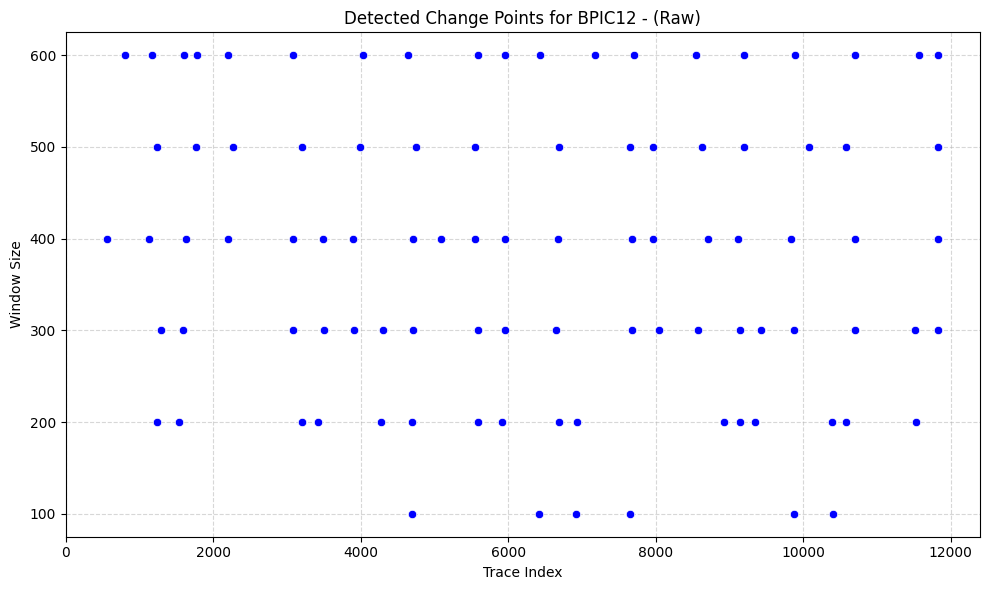

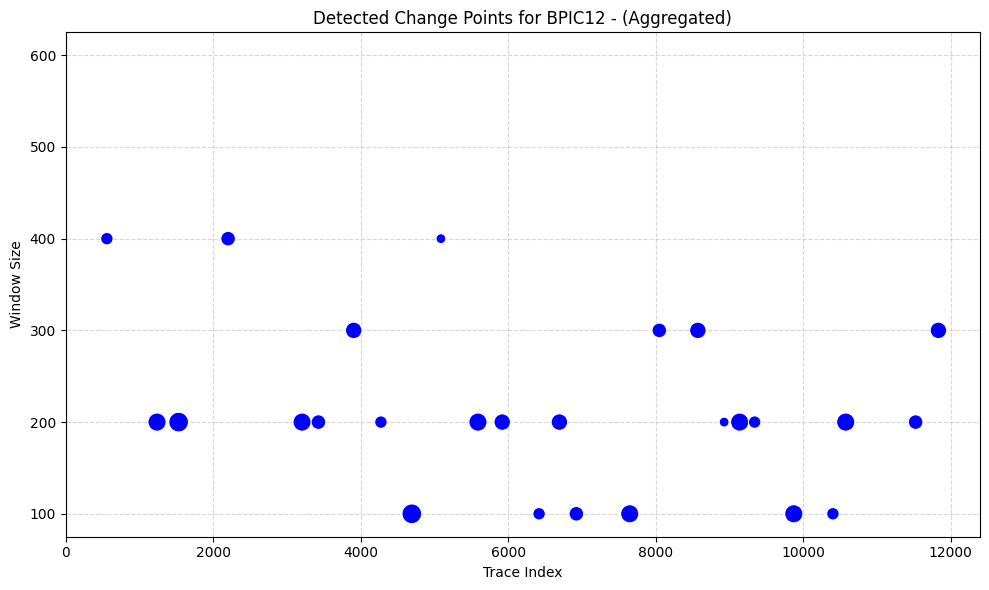

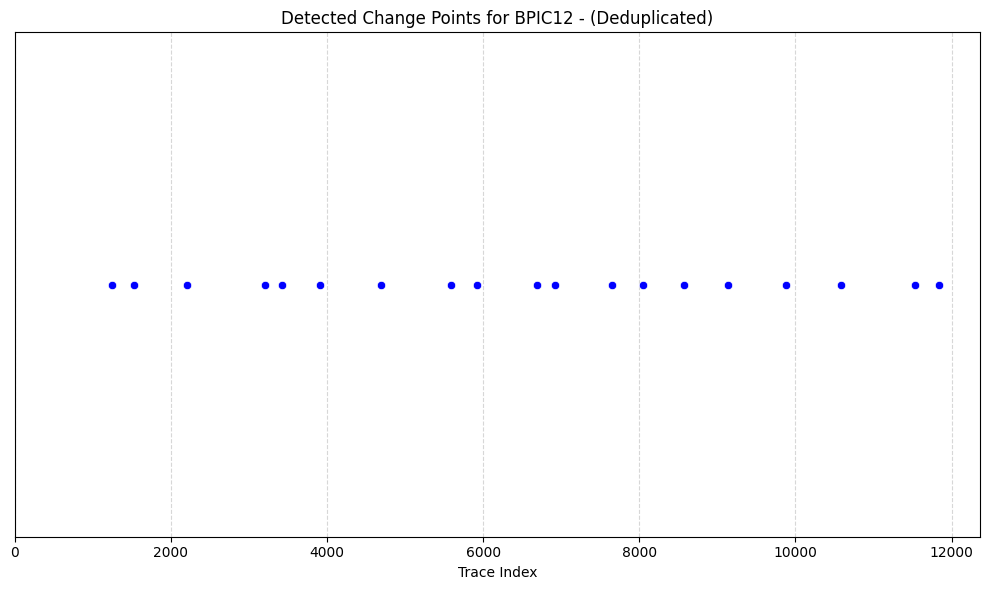

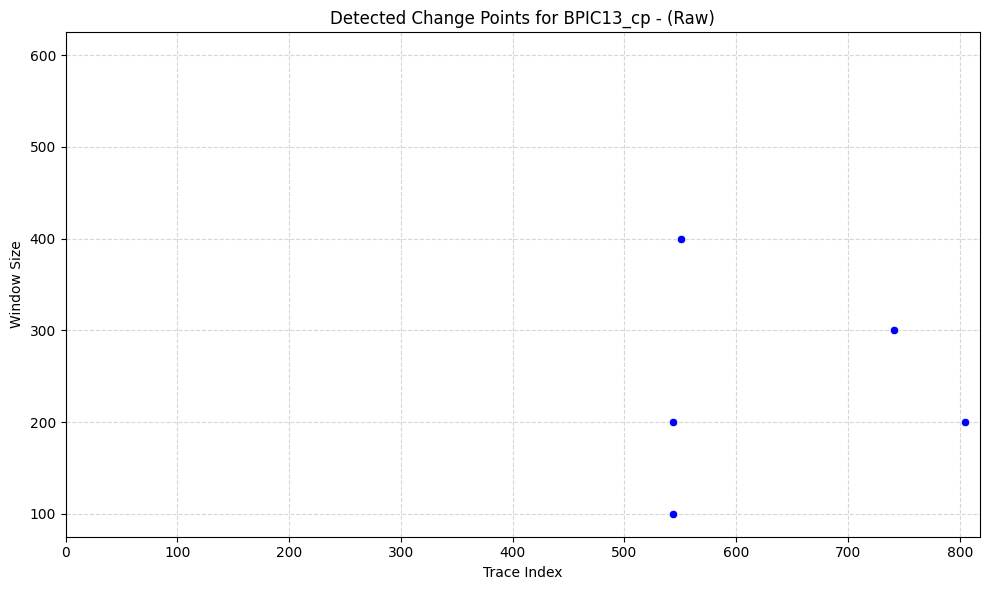

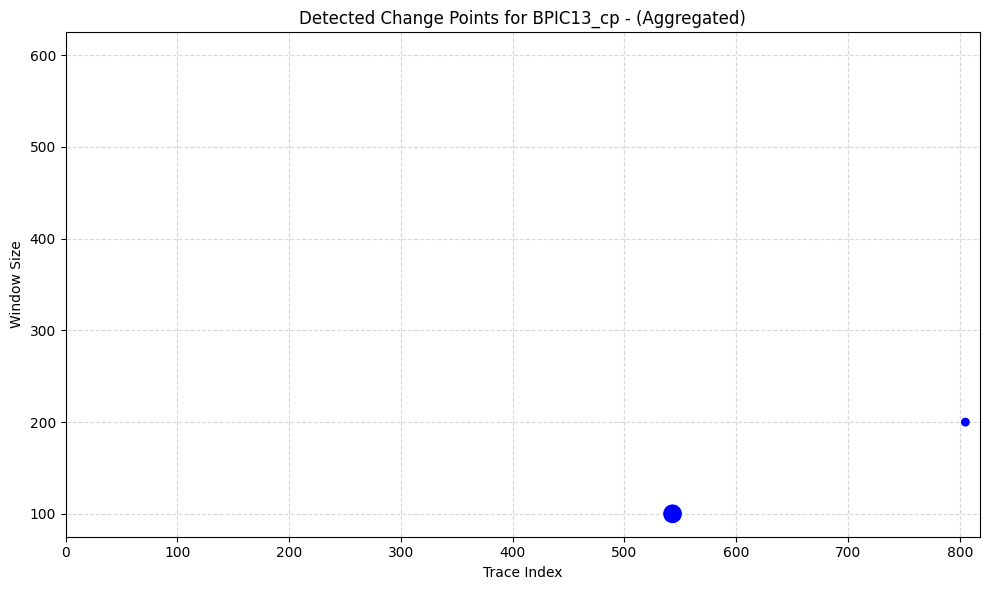

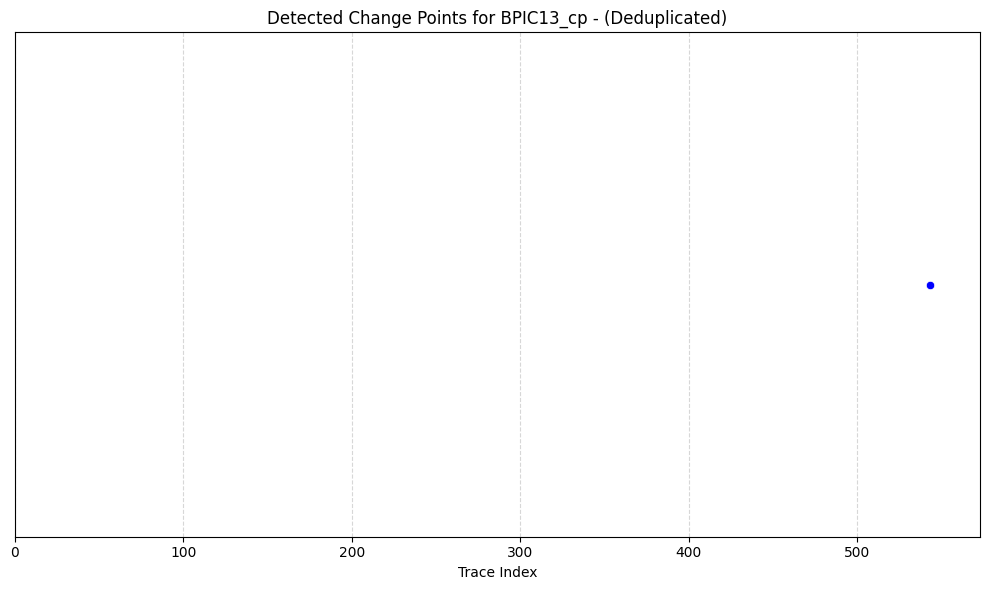

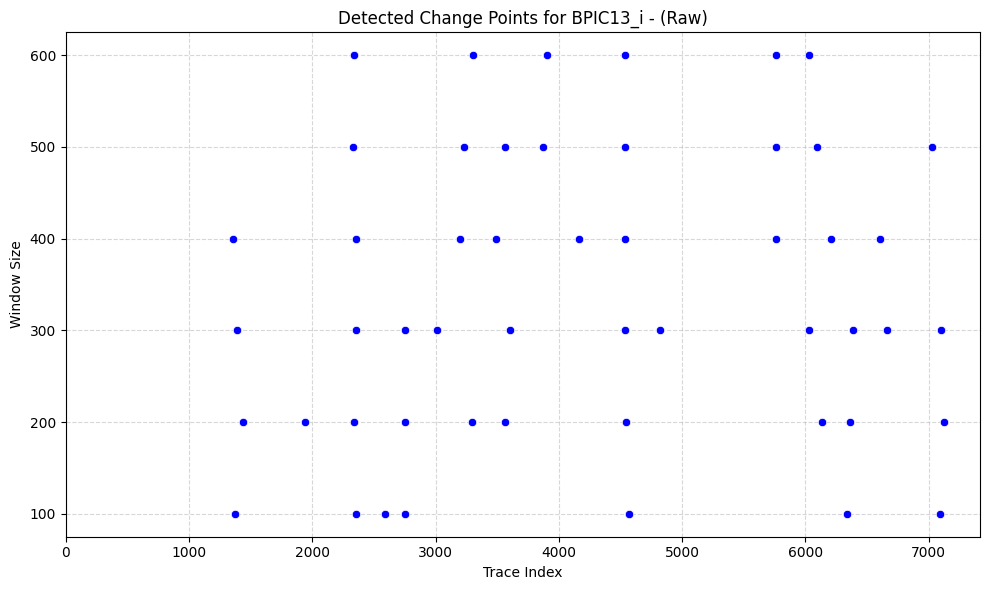

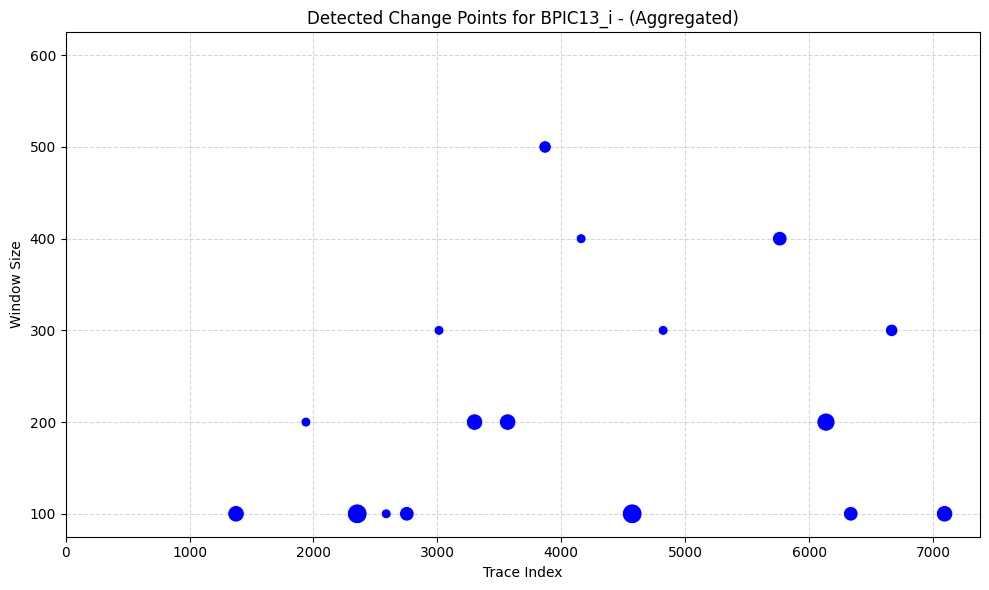

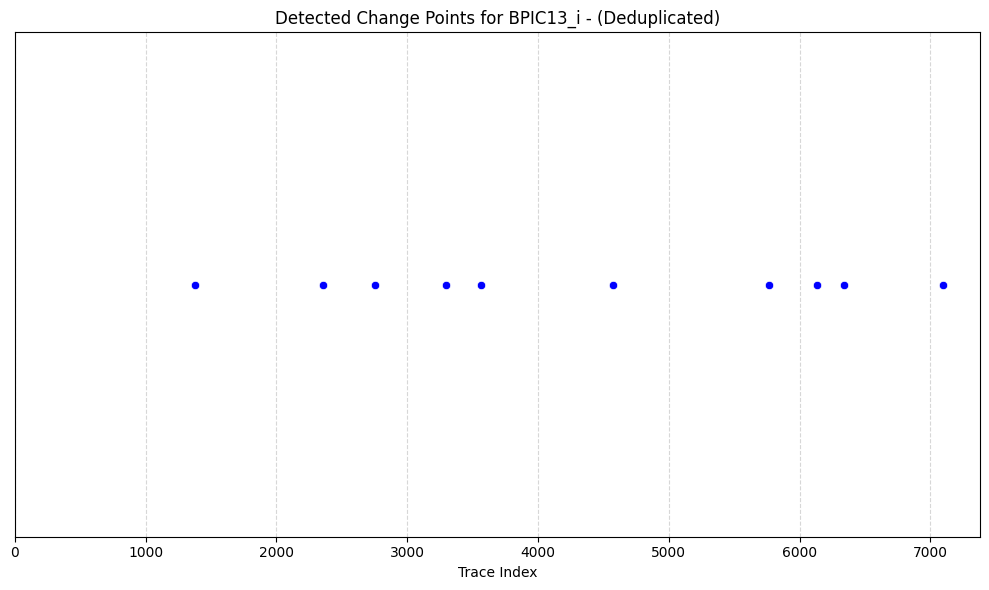

[INFO] No change points to plot for dataset BPIC14.
[INFO] No change points to plot for dataset BPIC14.
[INFO] No change points to plot for dataset BPIC14.


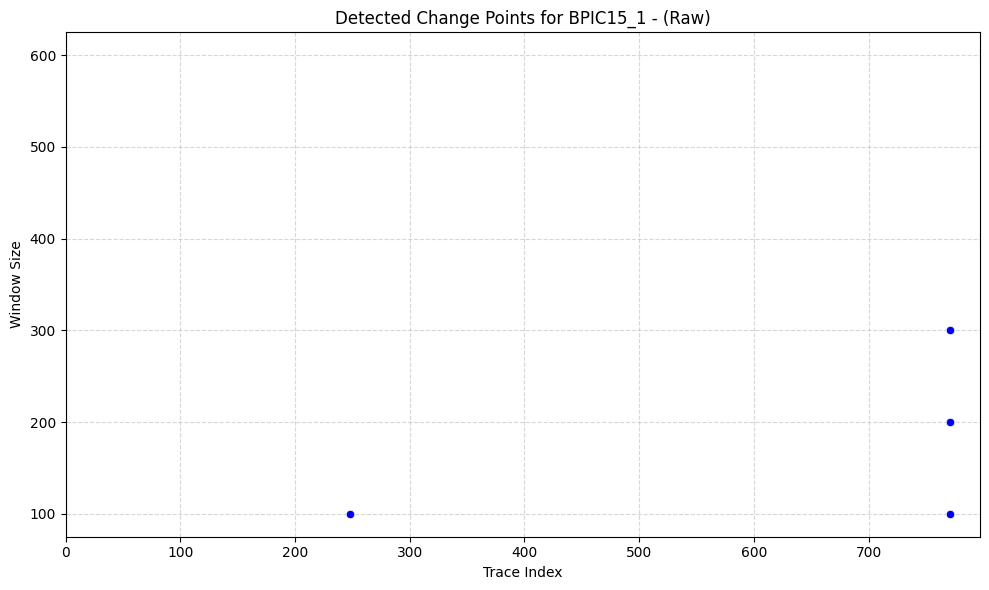

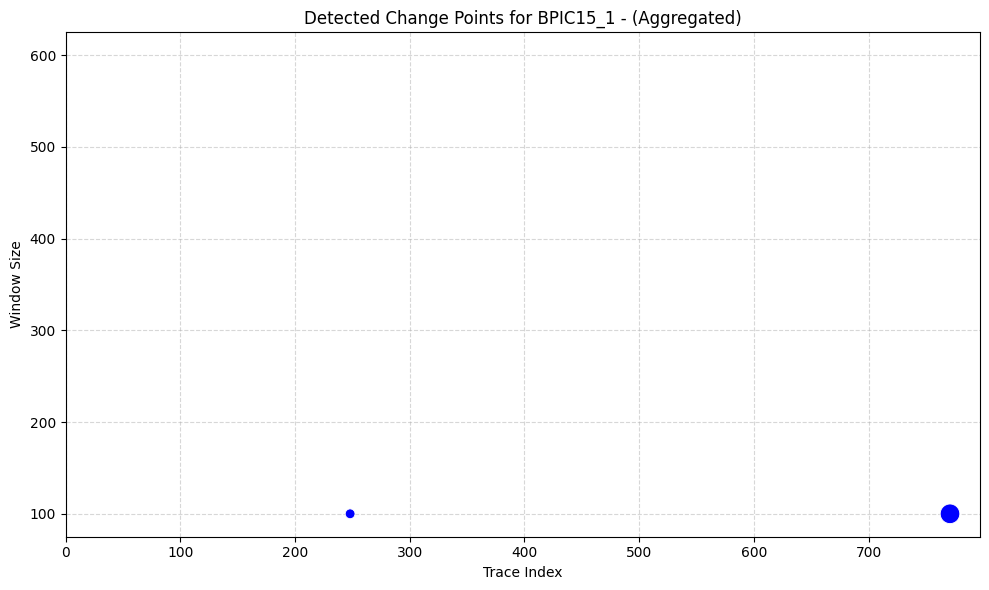

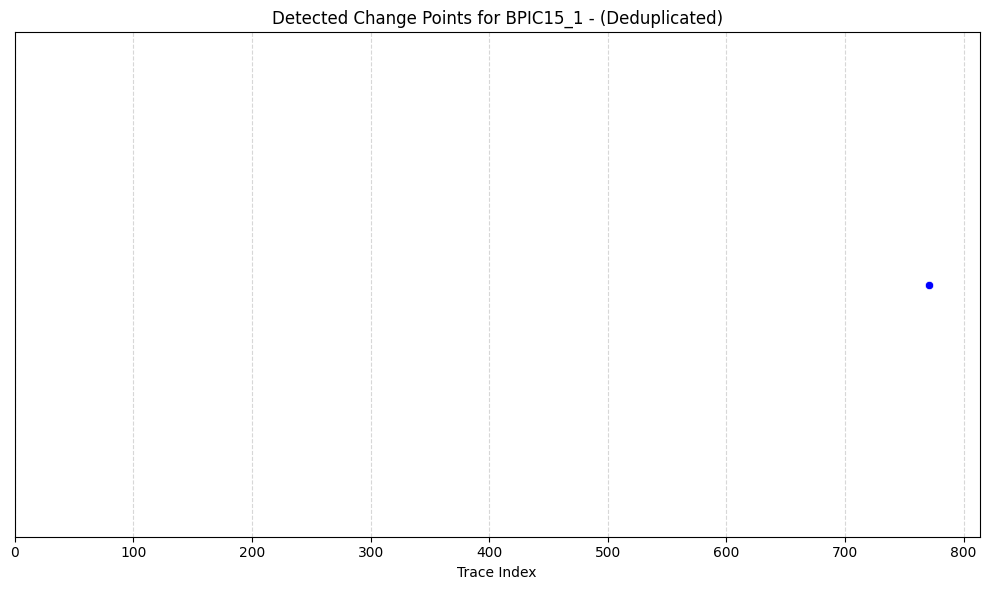

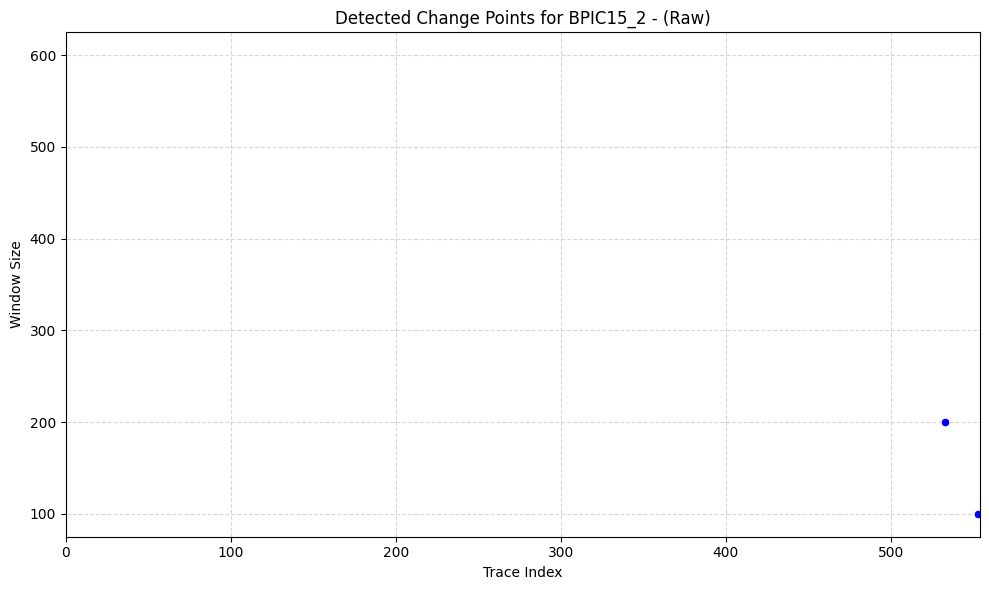

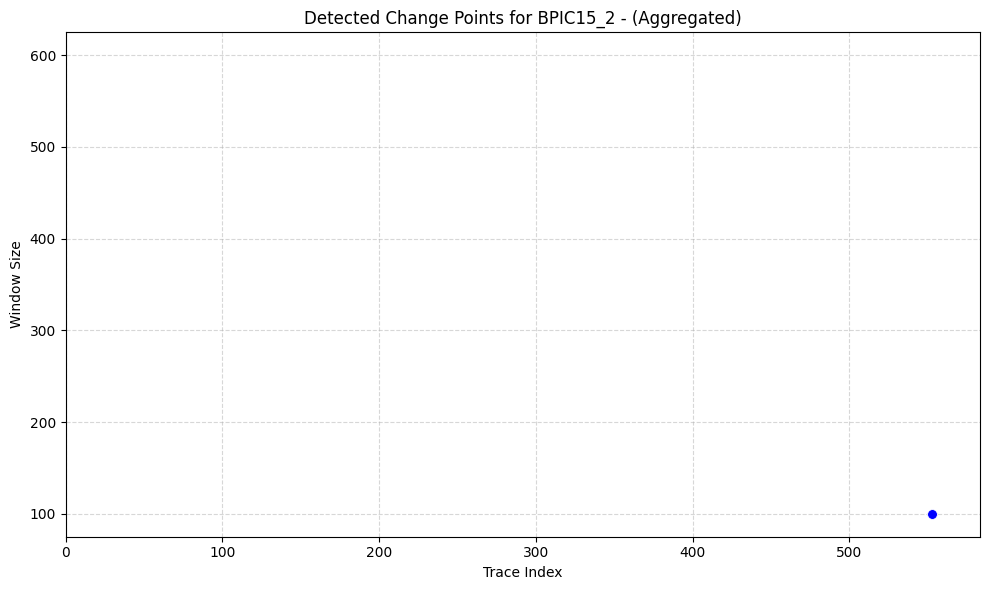

[INFO] No change points to plot for dataset BPIC15_2.


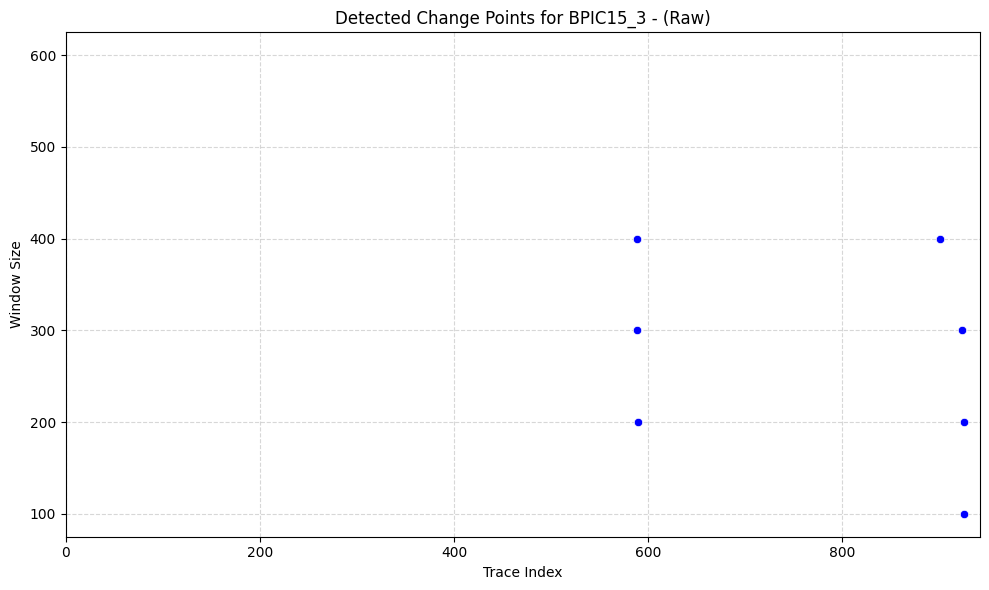

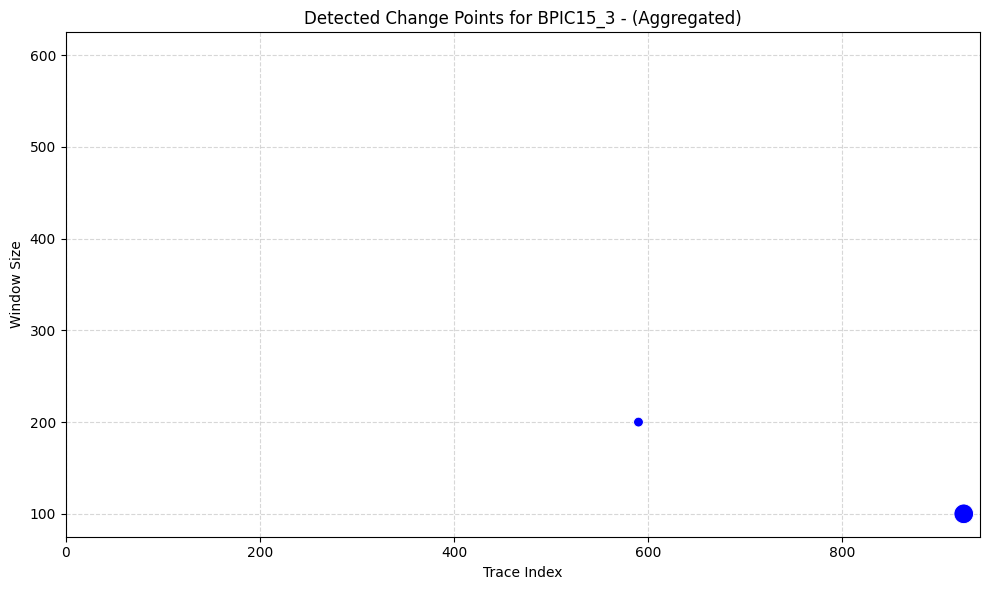

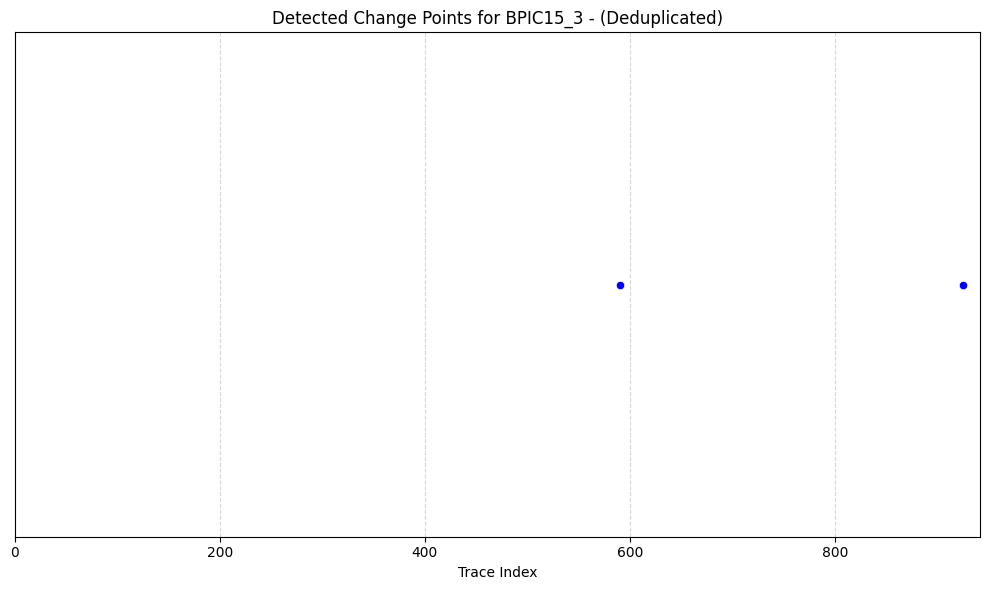

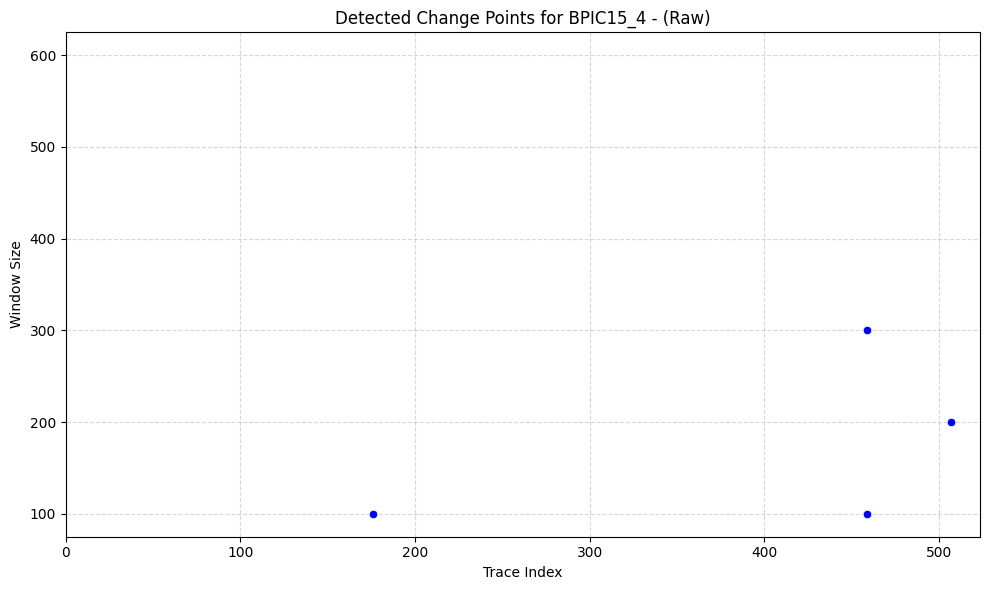

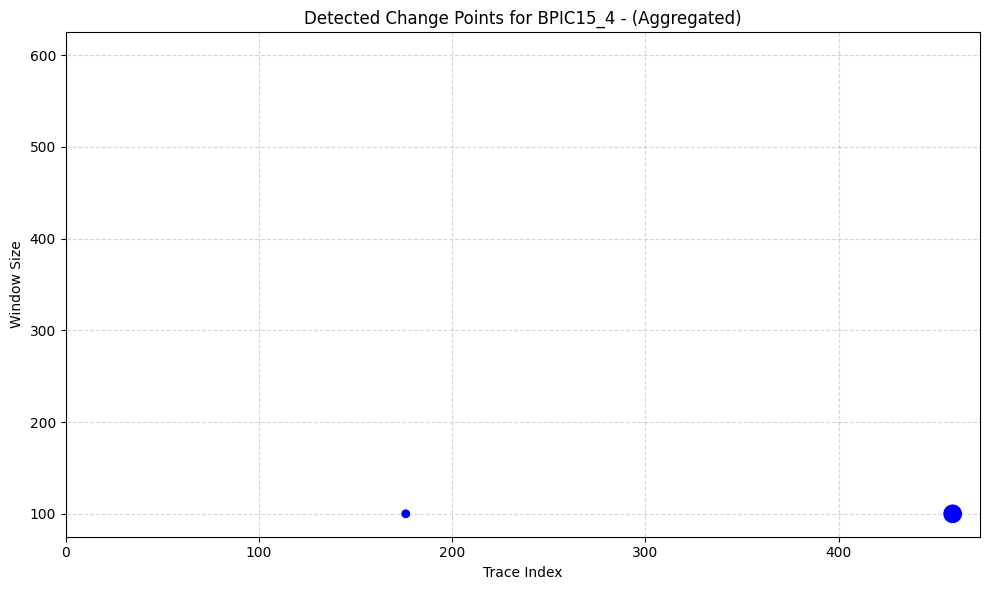

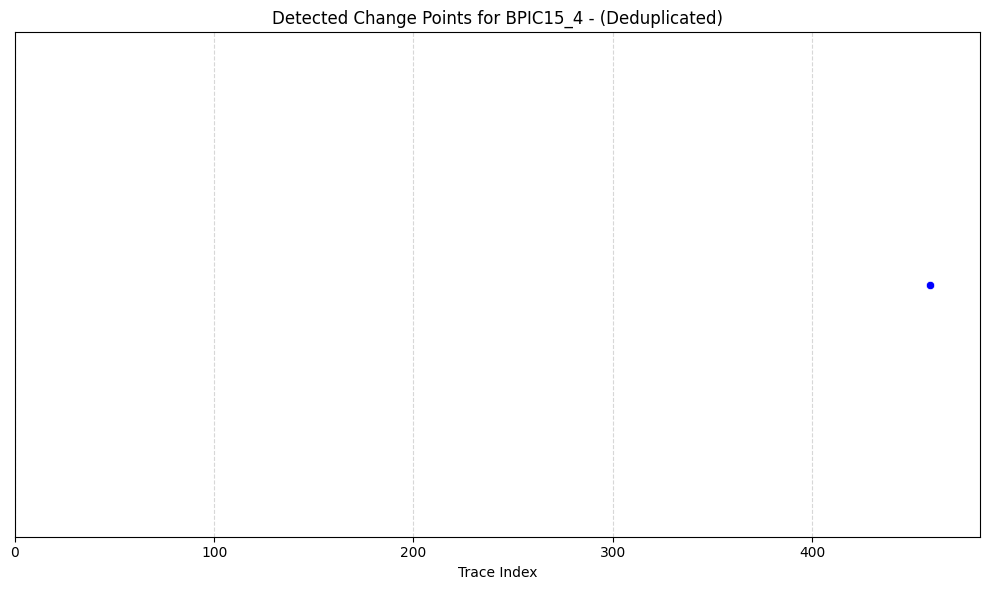

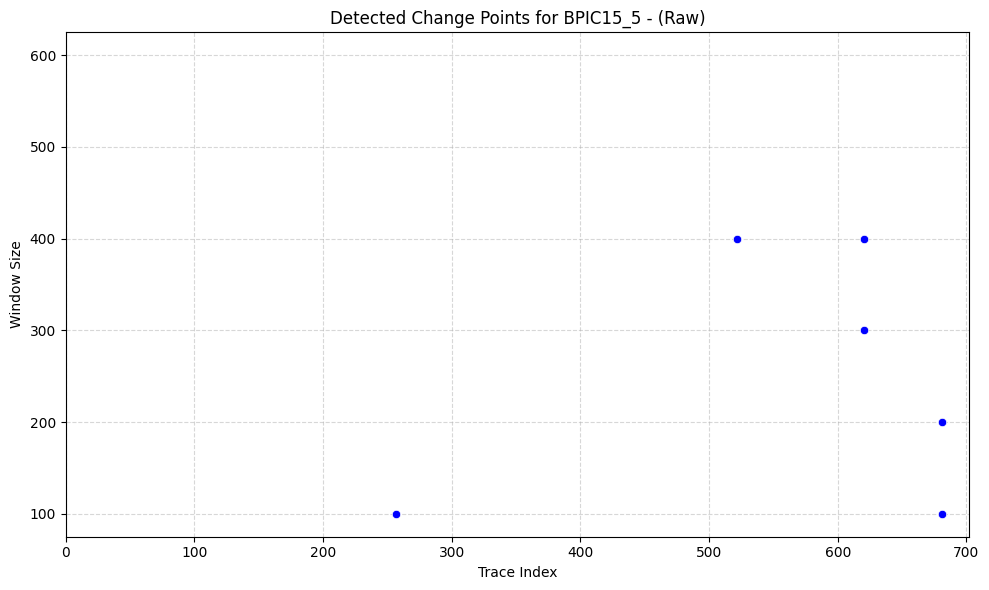

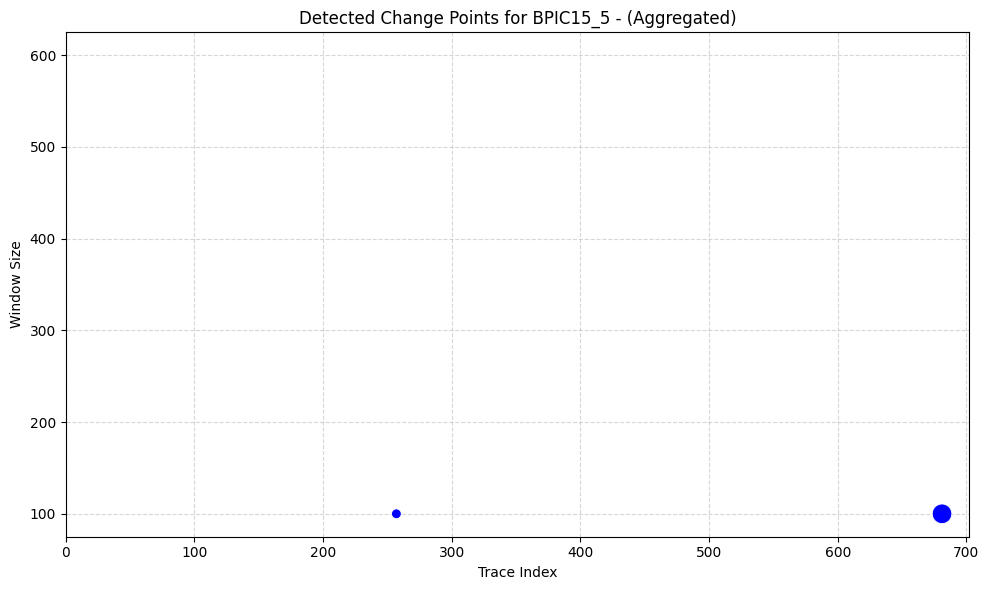

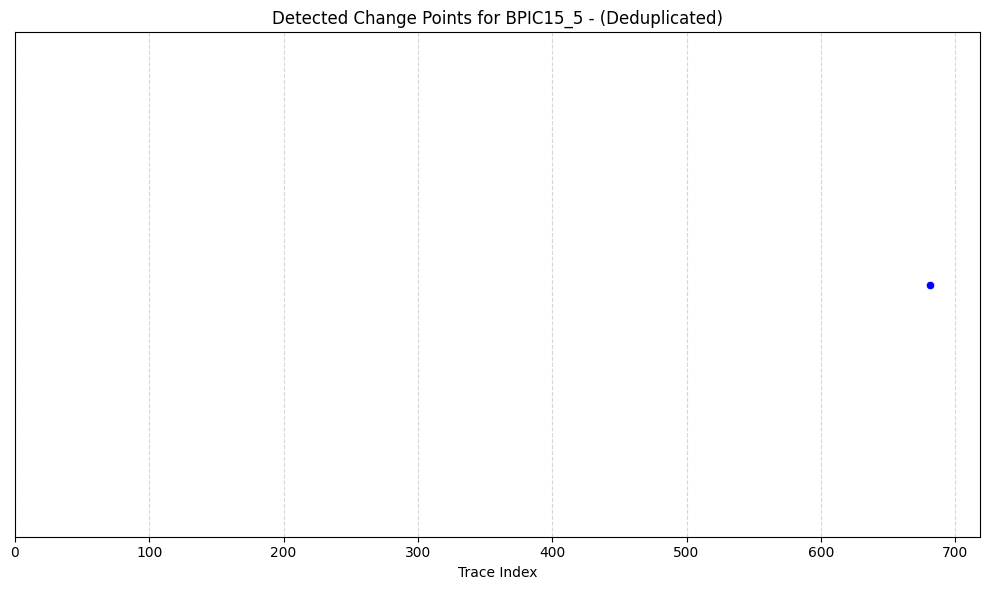

[INFO] No change points to plot for dataset BPIC17.
[INFO] No change points to plot for dataset BPIC17.
[INFO] No change points to plot for dataset BPIC17.
[INFO] No change points to plot for dataset BPIC18.
[INFO] No change points to plot for dataset BPIC18.
[INFO] No change points to plot for dataset BPIC18.
[INFO] No change points to plot for dataset BPIC19.
[INFO] No change points to plot for dataset BPIC19.
[INFO] No change points to plot for dataset BPIC19.


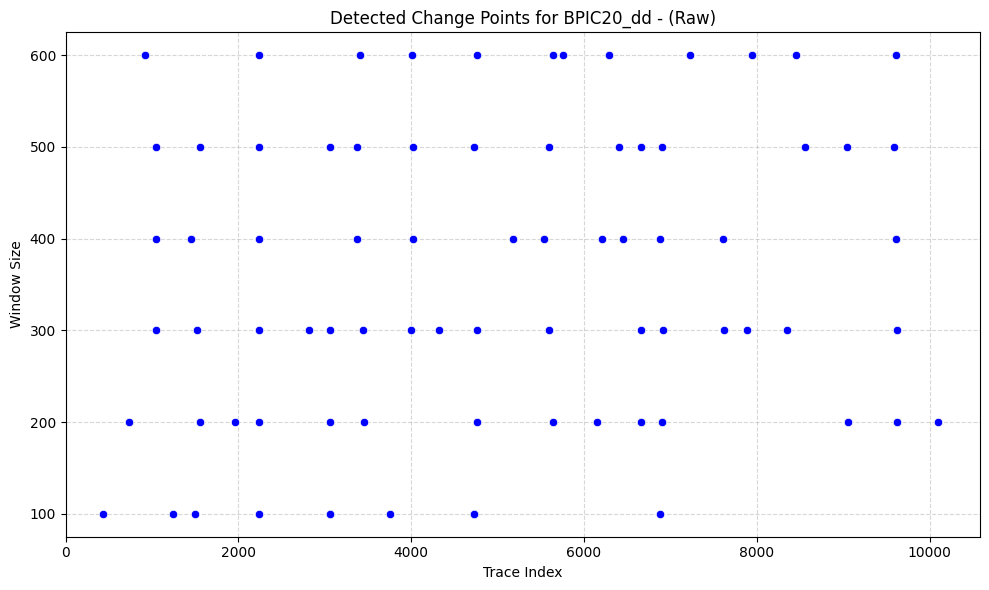

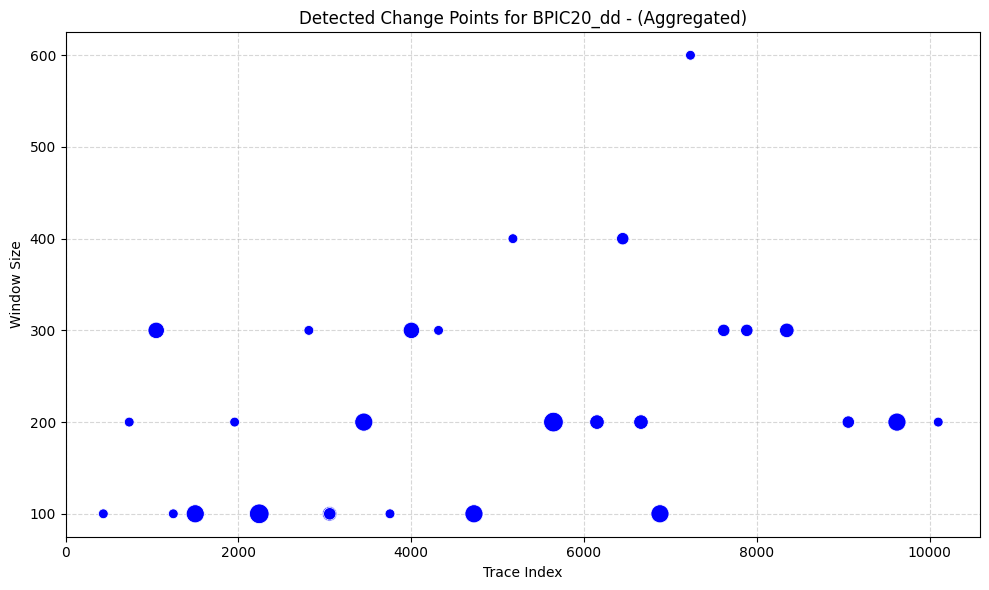

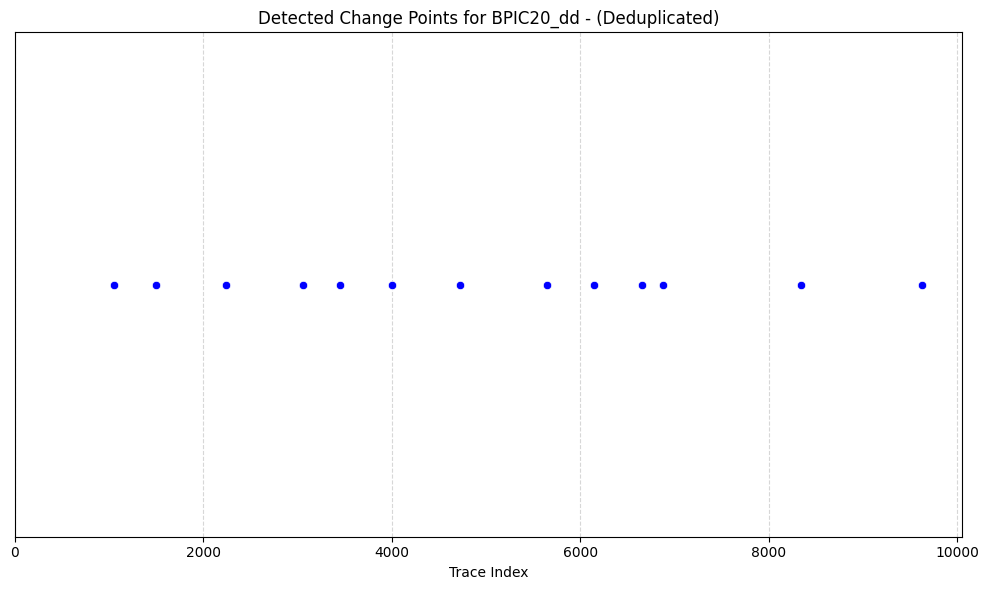

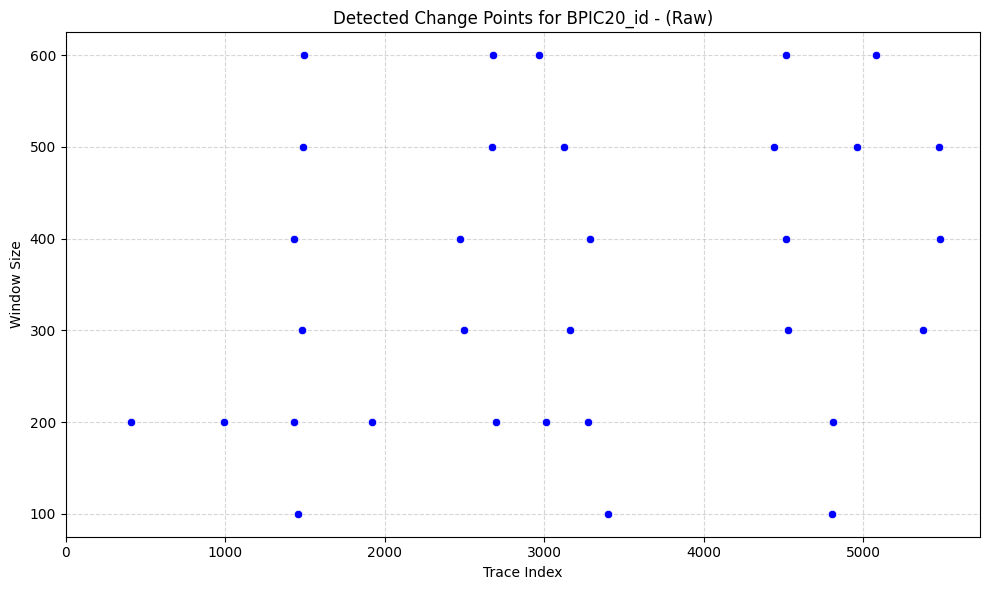

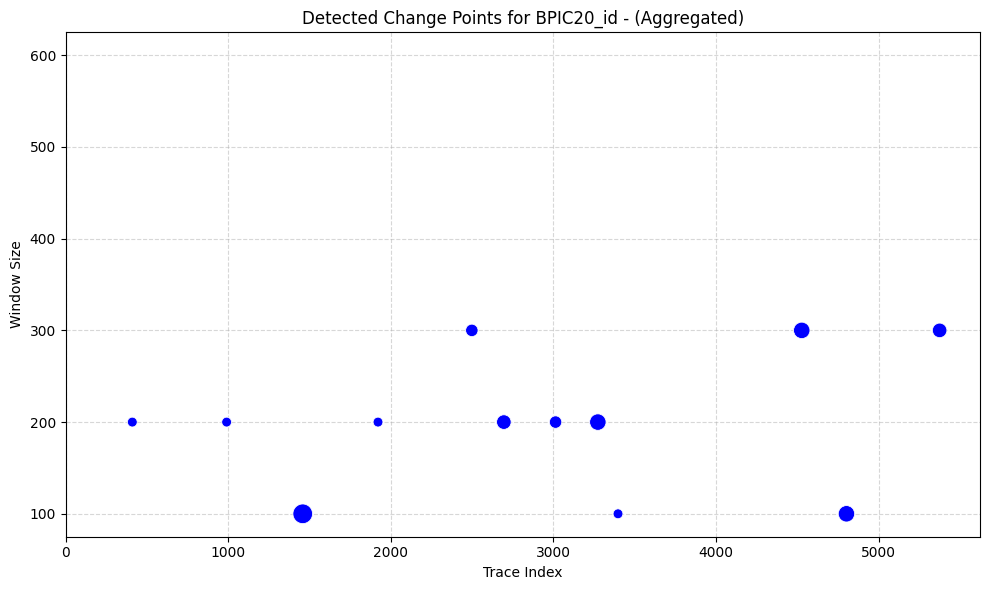

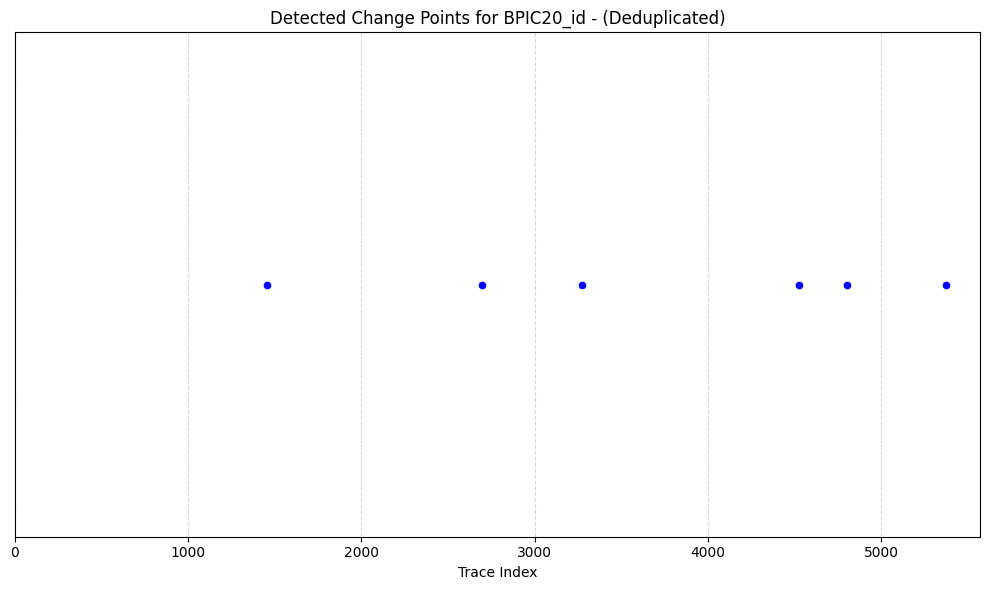

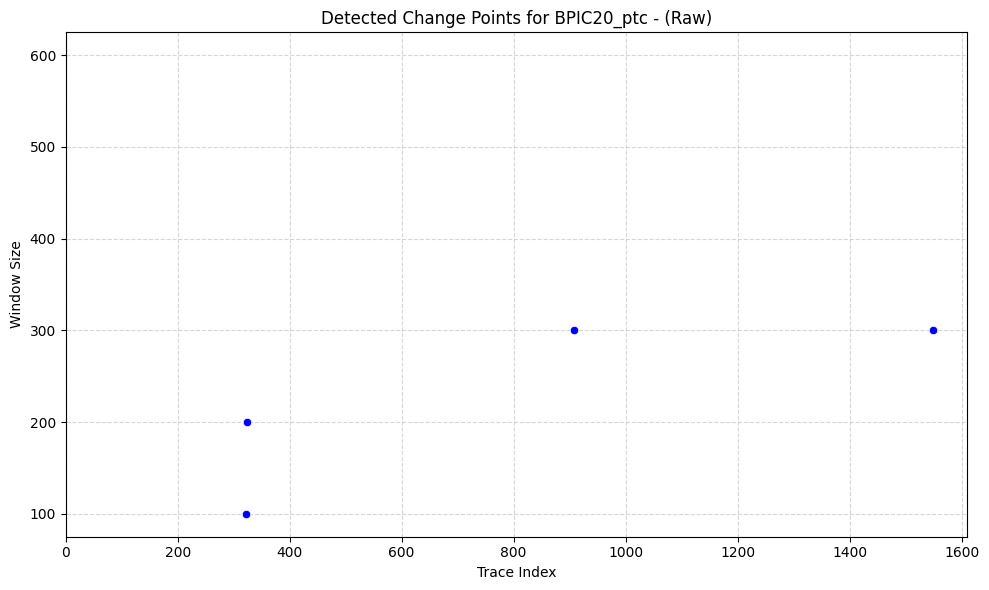

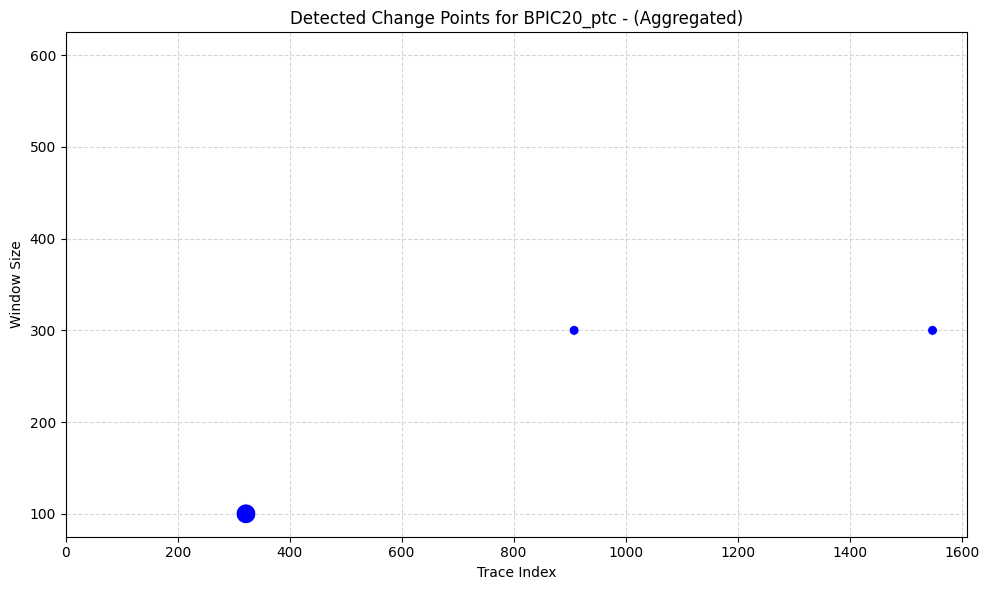

[INFO] No change points to plot for dataset BPIC20_ptc.


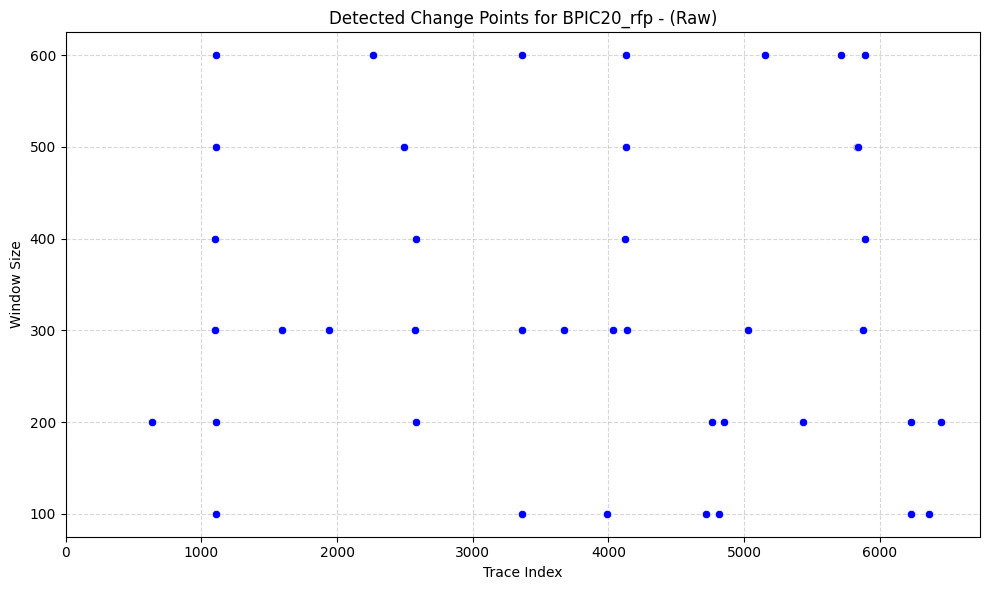

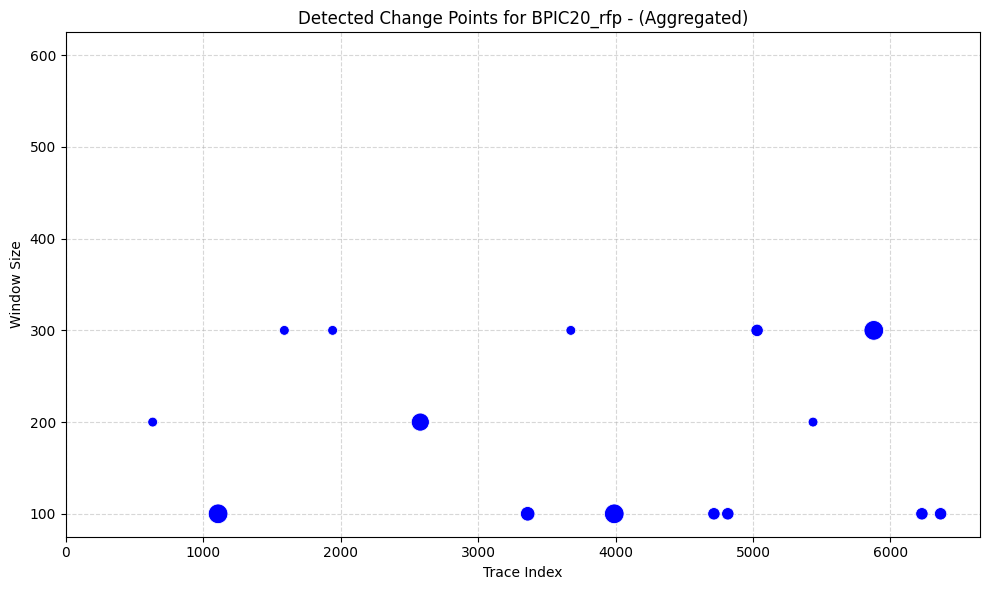

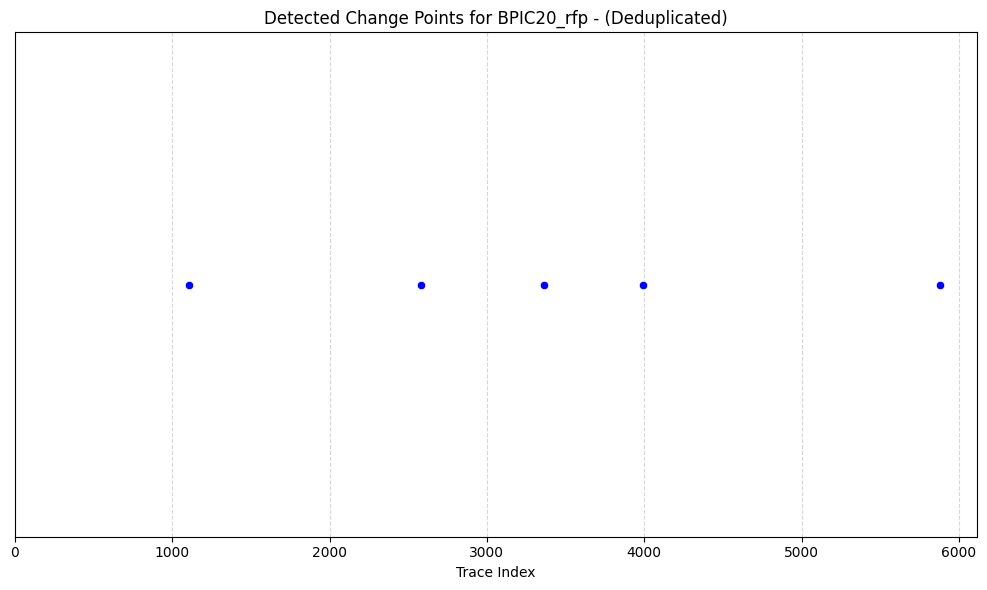

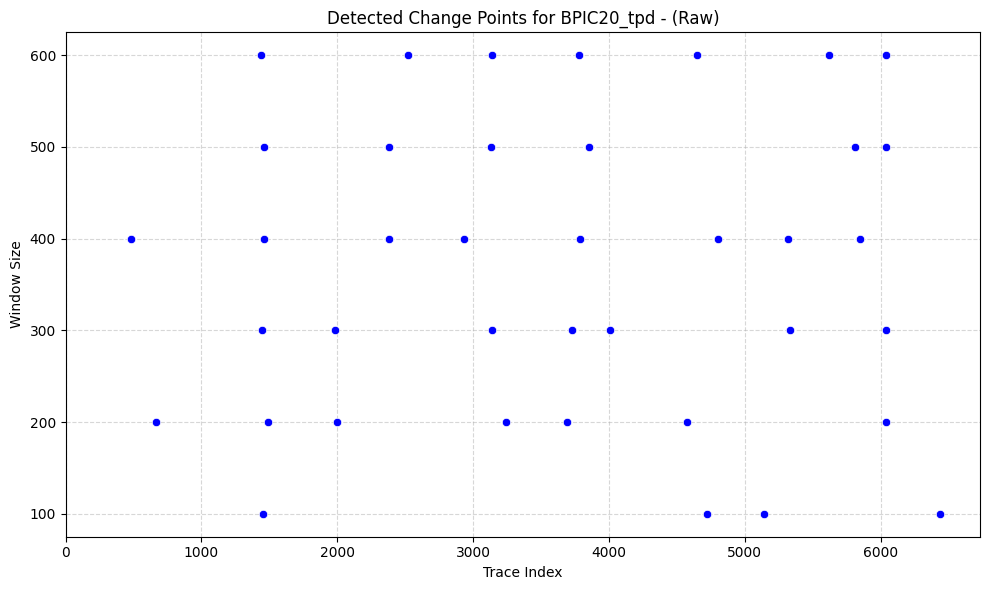

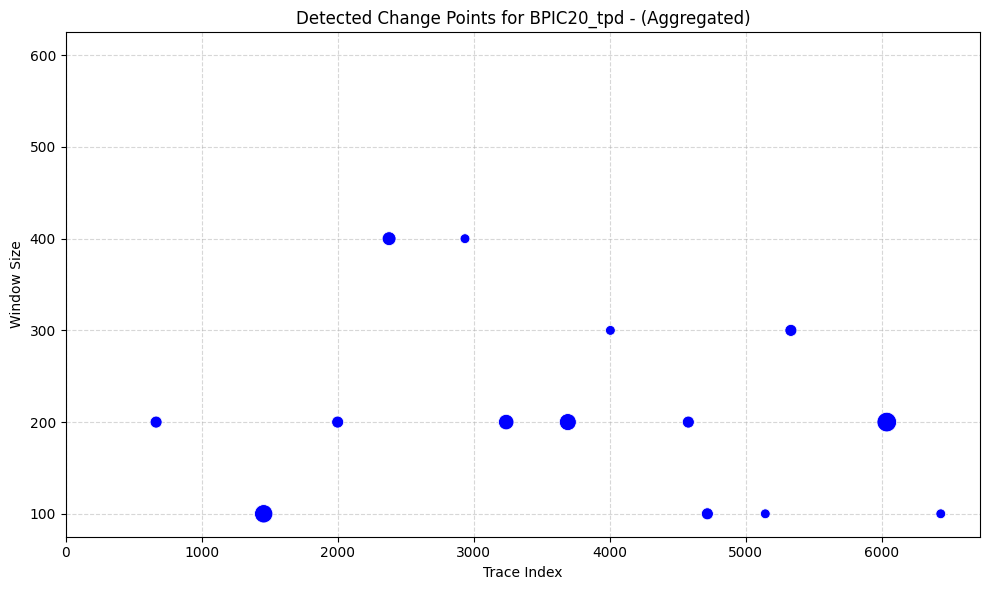

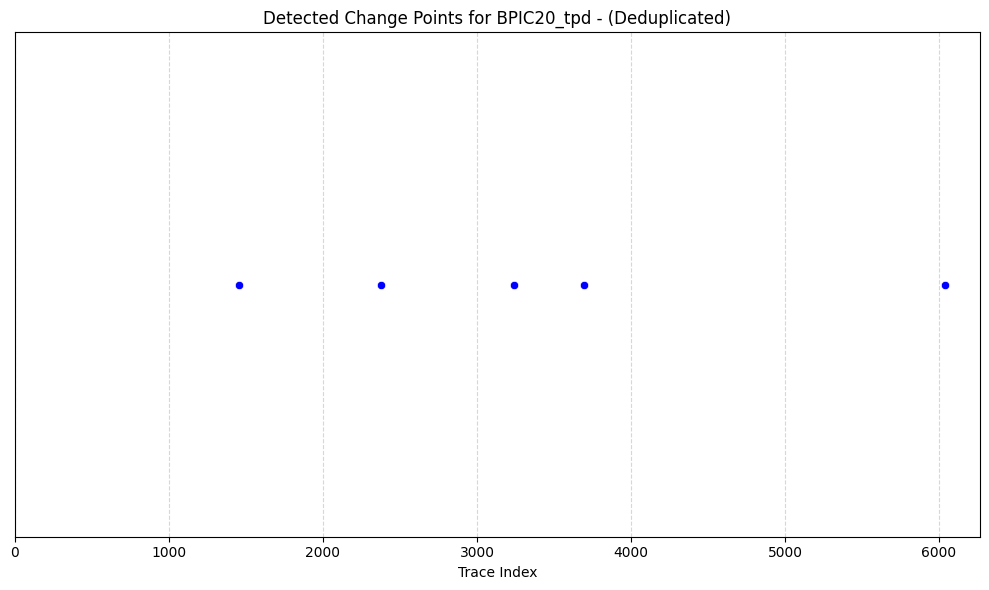

[INFO] No change points to plot for dataset CALL.
[INFO] No change points to plot for dataset CALL.
[INFO] No change points to plot for dataset CALL.
[INFO] No change points to plot for dataset ITHD.
[INFO] No change points to plot for dataset ITHD.
[INFO] No change points to plot for dataset ITHD.


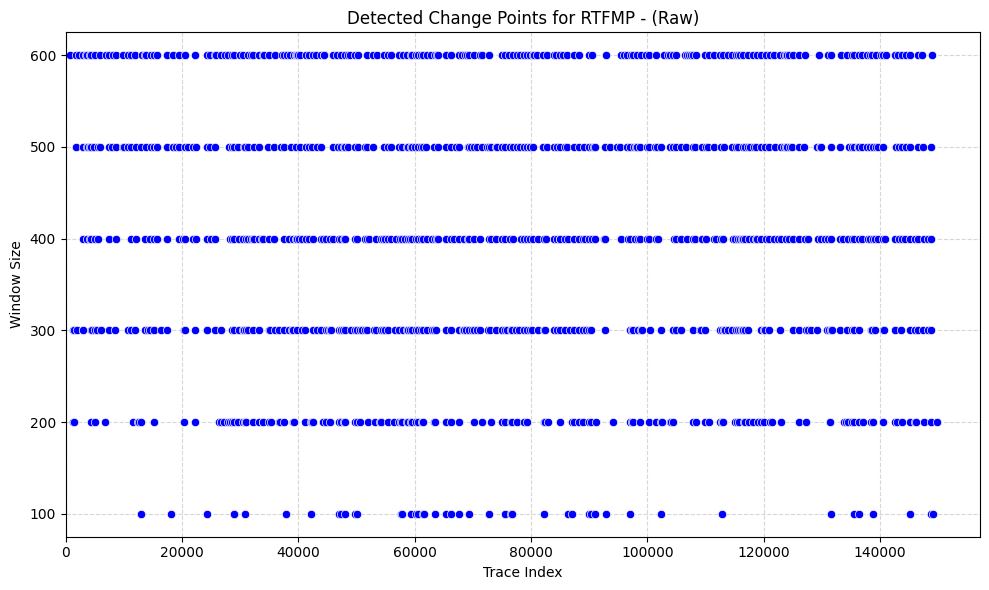

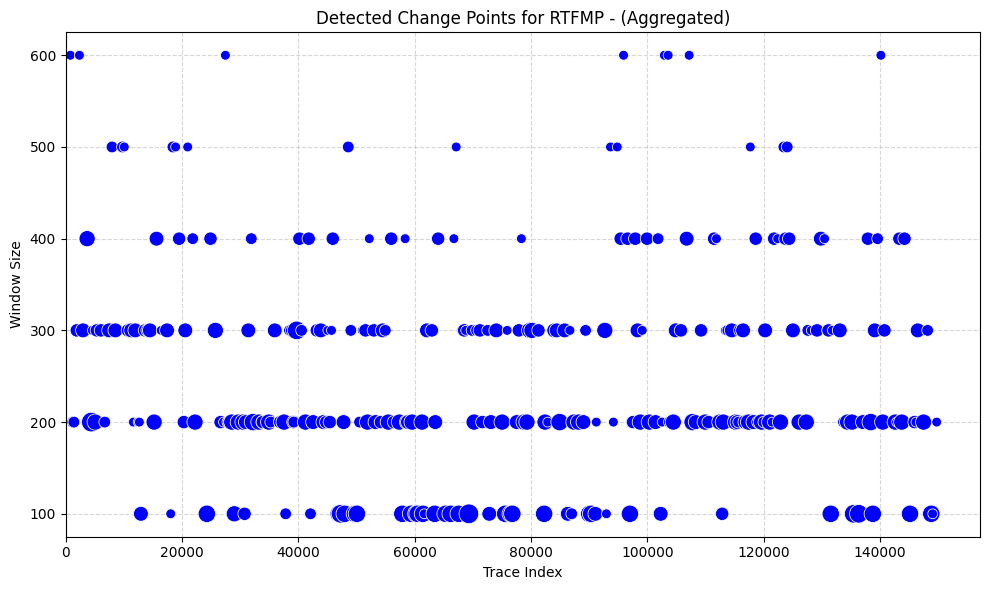

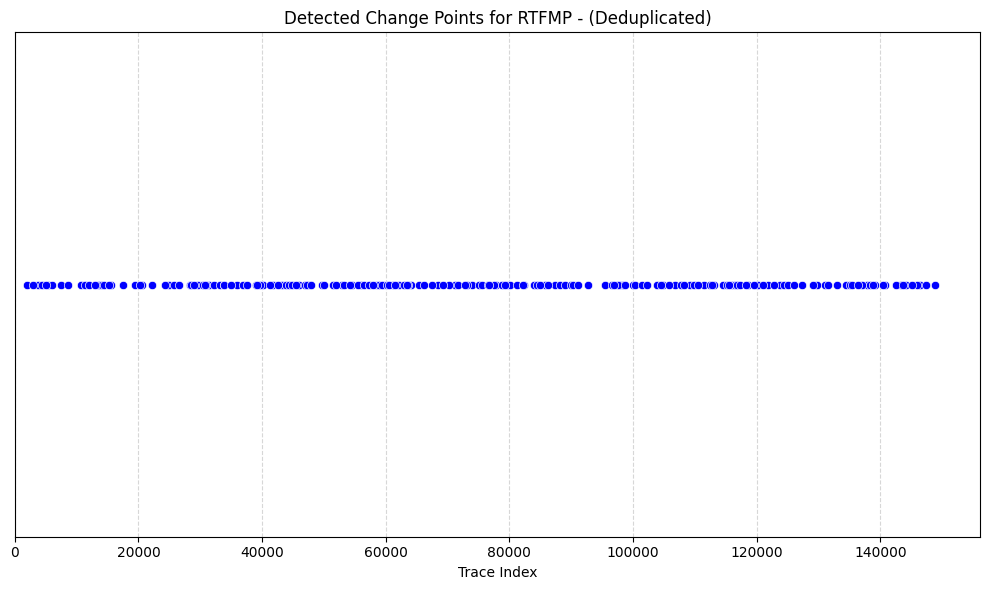

[INFO] No change points to plot for dataset SEPSIS.
[INFO] No change points to plot for dataset SEPSIS.
[INFO] No change points to plot for dataset SEPSIS.


In [11]:
# Plot original and deduplicated points
for dataset, df in change_points_dict.items():
    plot_change_points(dataset, change_points_dict[dataset], input_type='list_of_configurations', y_axis_label="Window Size", configuration_labels=window_sizes, title_suffix="(Raw)")
    plot_change_points(dataset, aggregated_cp_dict[dataset], input_type='dataframe', config_column_in_df='window_size', y_axis_label="Window Size", configuration_labels=window_sizes, title_suffix="(Aggregated)")
    plot_change_points(dataset, deduplicated_cp_dict[dataset], input_type='list_of_cps', y_axis_label="Window Size", configuration_labels=window_sizes, title_suffix="(Deduplicated)")

In [12]:
# import pandas as pd

# # Read both CSV files
# df1 = pd.read_csv("cdrift-evaluation/algorithm_results.csv")
# df2 = pd.read_csv("cdrift-evaluation/algorithm_results_original.csv")

# # Combine rows, aligning columns by name
# merged_df = pd.concat([df1, df2], ignore_index=True)

# # Save to new CSV
# merged_df.to_csv("cdrift-evaluation/merged_results.csv", index=False)

## Process Graphs

In [13]:
parameter_setting_names = [
    "processGraphsPSmallWSmall",
    "processGraphsPSmallWDefault",
    "processGraphsPSmallWLarge",
    "processGraphsPDefaultWSmall",
    "processGraphsPDefaultWDefault",
    "processGraphsPDefaultWLarge",
    "processGraphsPLargeWSmall",
    "processGraphsPLargeWDefault",
    "processGraphsPLargeWLarge"
]

In [14]:
# Load all change points into a consistent dictionary of DataFrames
change_points_dict = {}

for dataset in data_dictionary:
    dataset_cps = defaultdict(list)  # maps window_size → list of change points

    for parameter_setting_name in parameter_setting_names:
        results_path = f'results/drift_detection/{dataset}/results_{dataset}_{parameter_setting_name}.csv'

        if os.path.exists(results_path):
            results_df = pd.read_csv(results_path)

            for _, row in results_df.iterrows():
                if row.get('calc_drift_id') == 'na':
                    break

                change_point = row.get('calc_change_index')

                if pd.notna(change_point):
                    dataset_cps[parameter_setting_name].append(int(change_point))

    # convert defaultdict to normal dict before storing
    change_points_dict[dataset] = dict(dataset_cps)

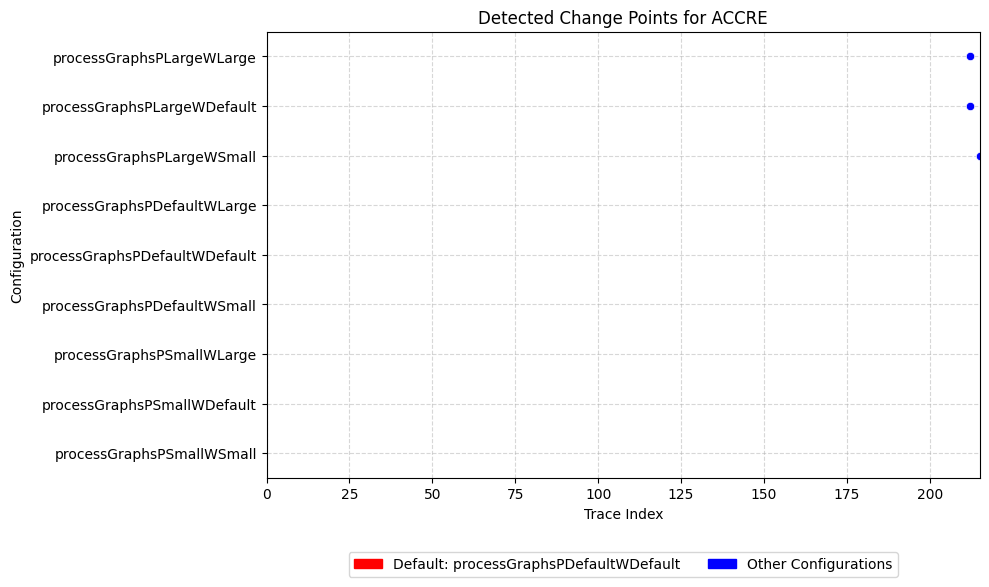

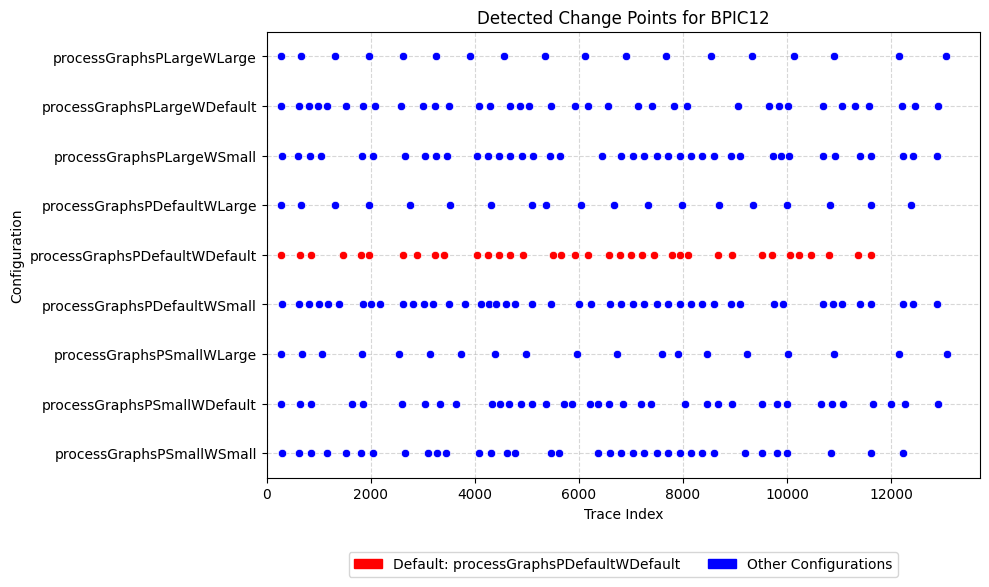

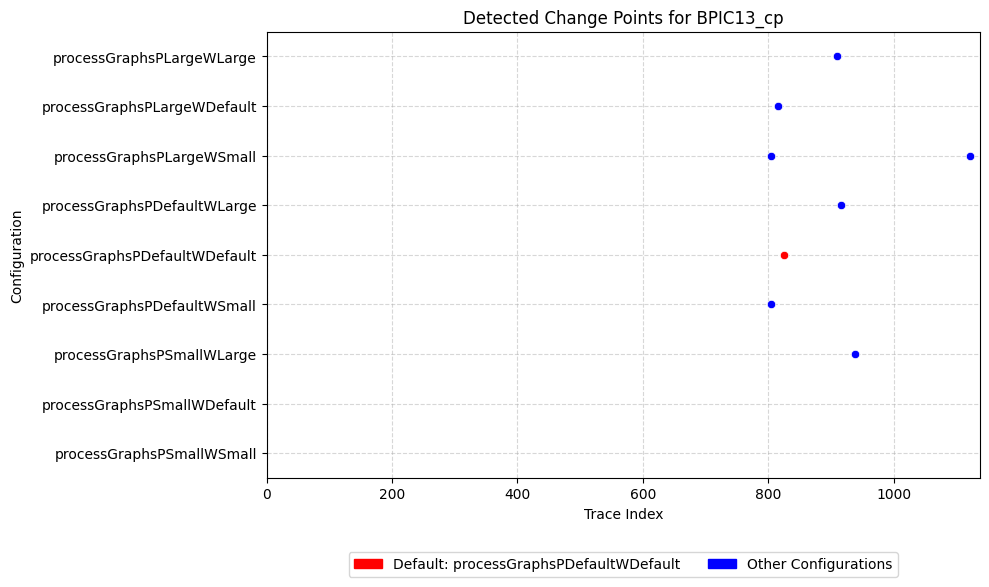

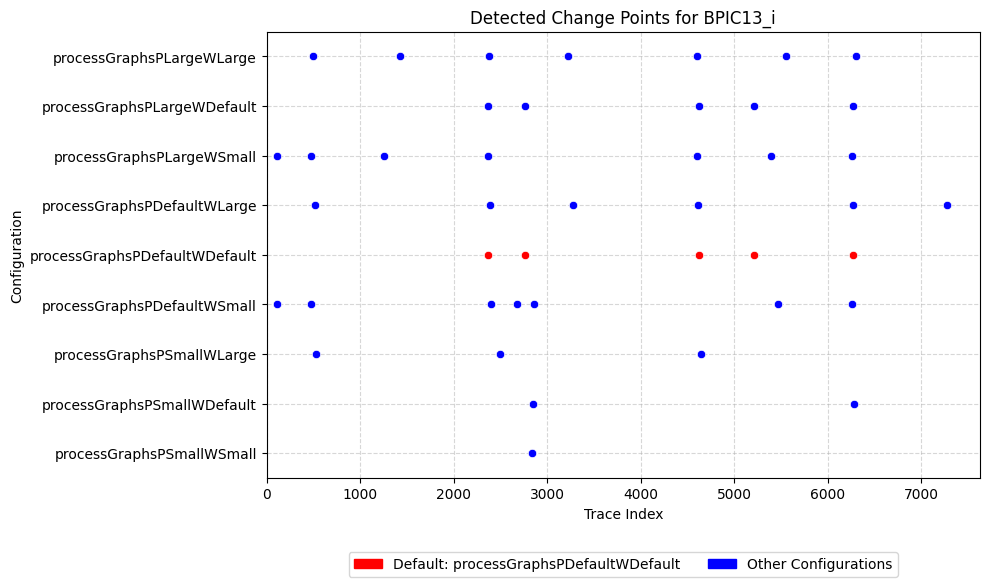

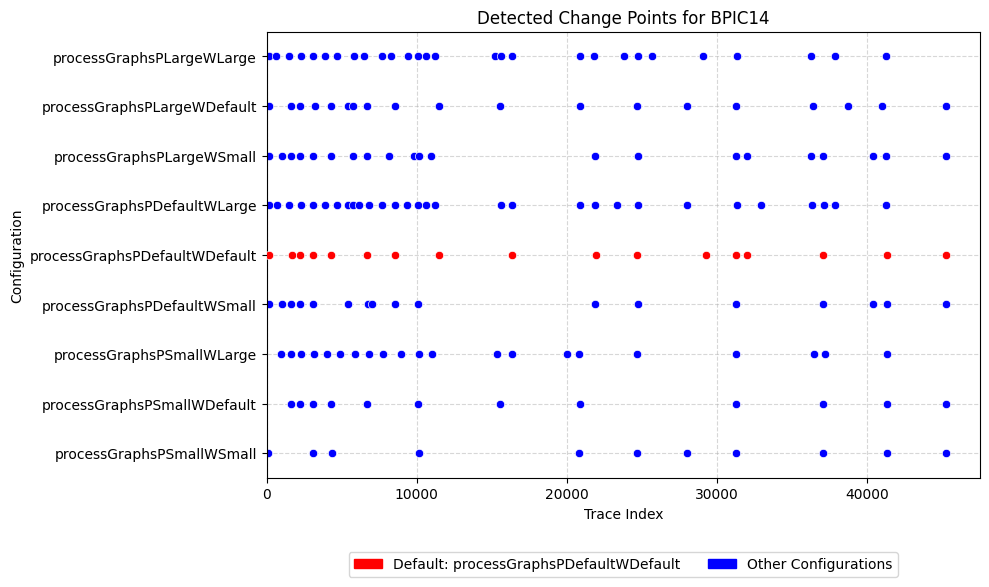

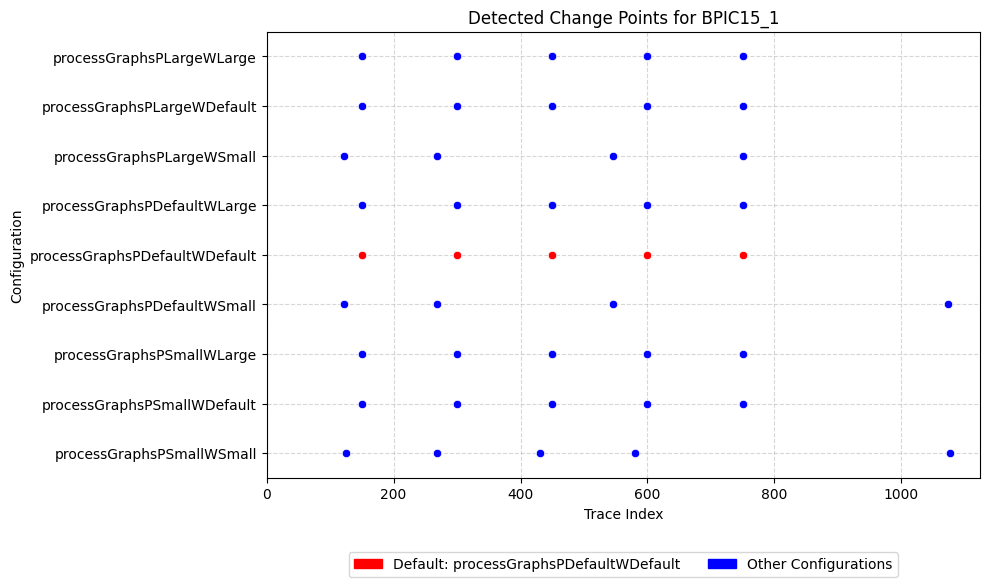

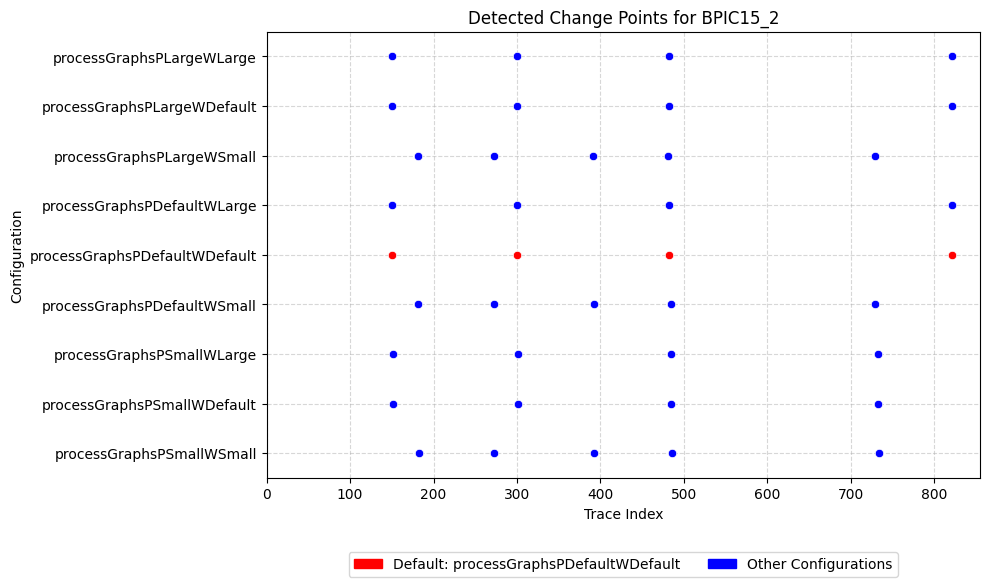

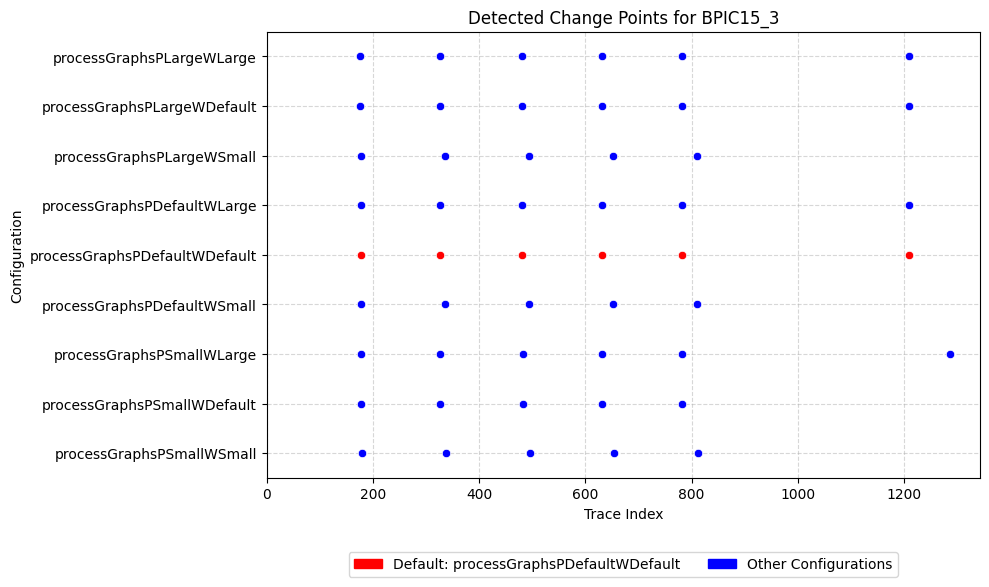

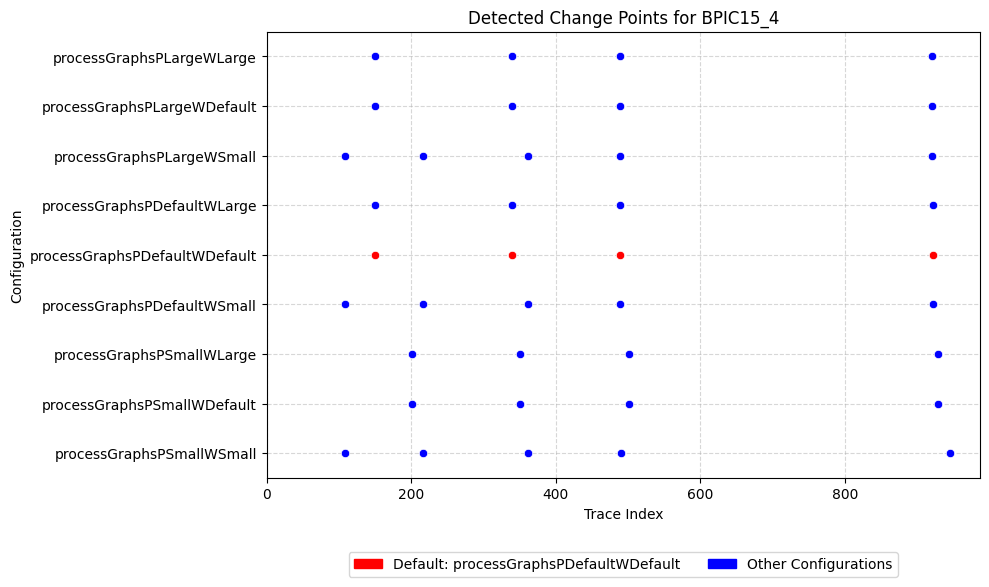

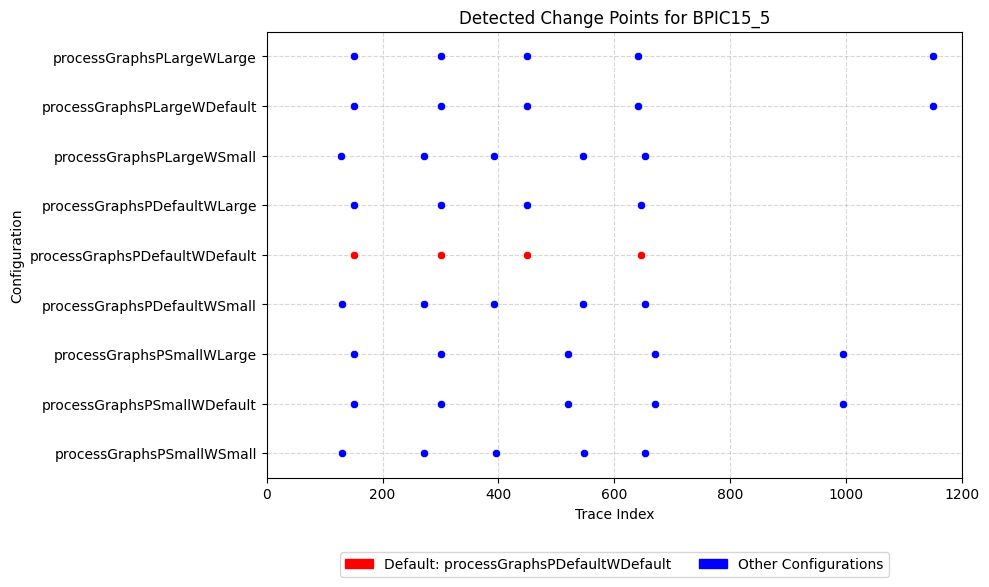

[INFO] No change points to plot for dataset BPIC17.
[INFO] No change points to plot for dataset BPIC18.
[INFO] No change points to plot for dataset BPIC19.


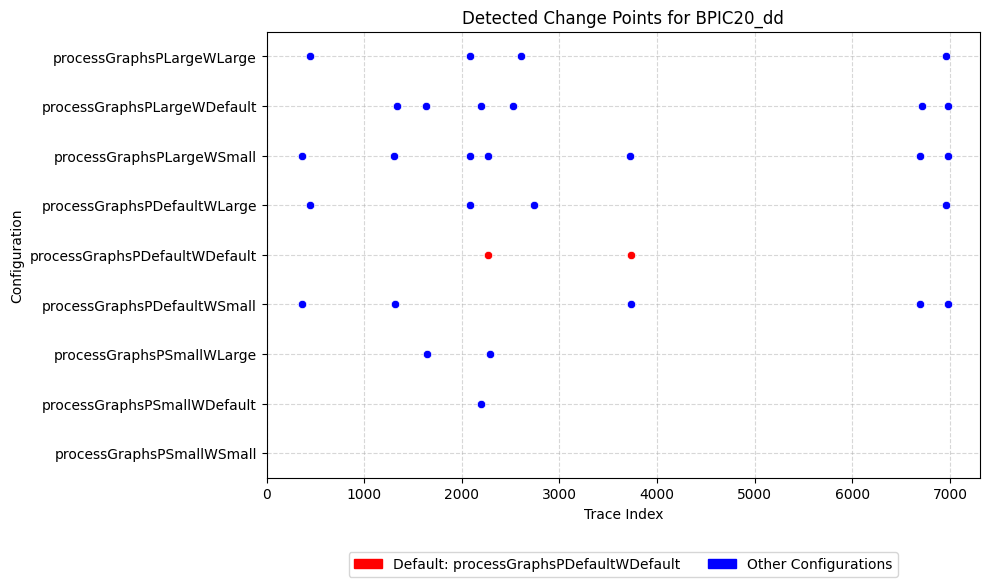

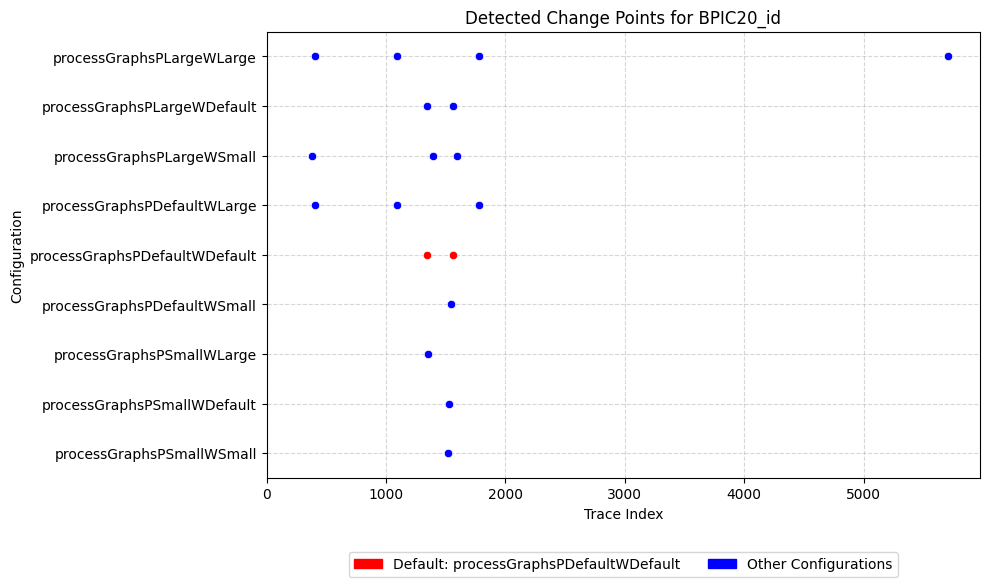

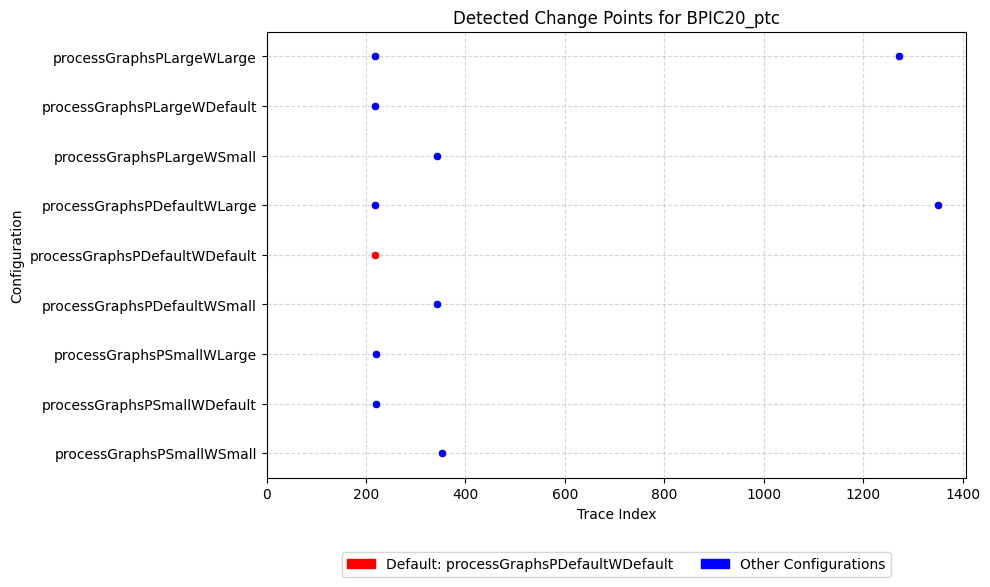

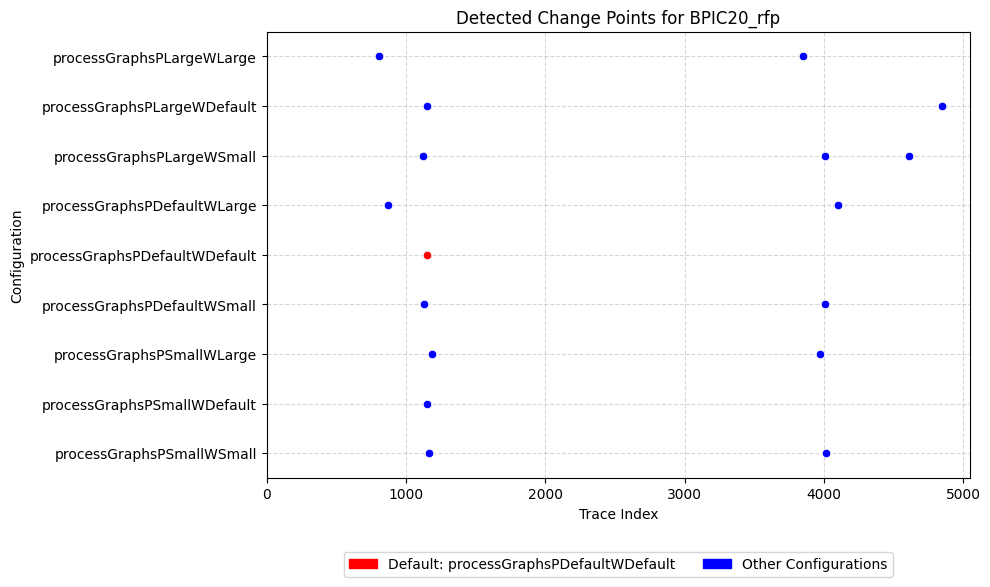

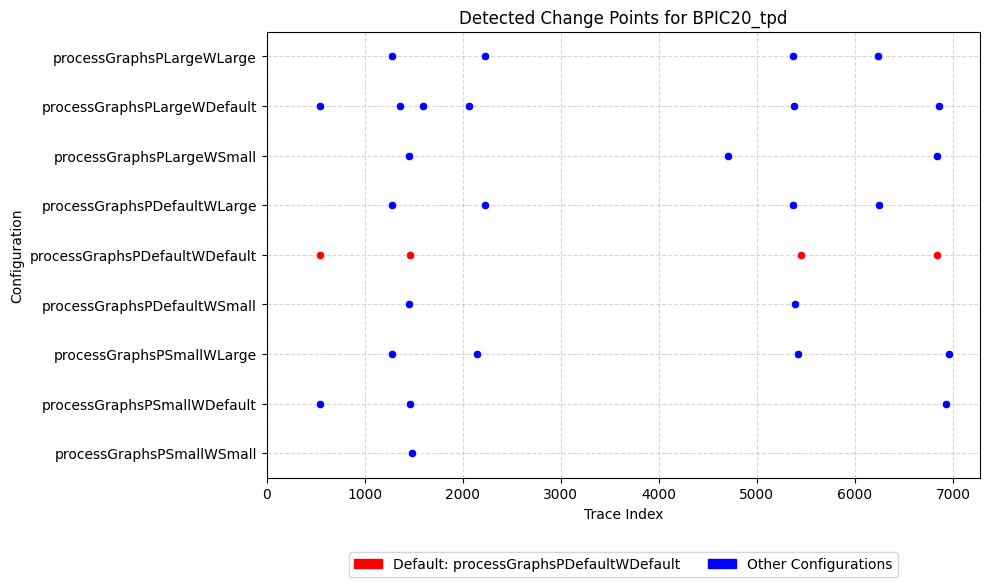

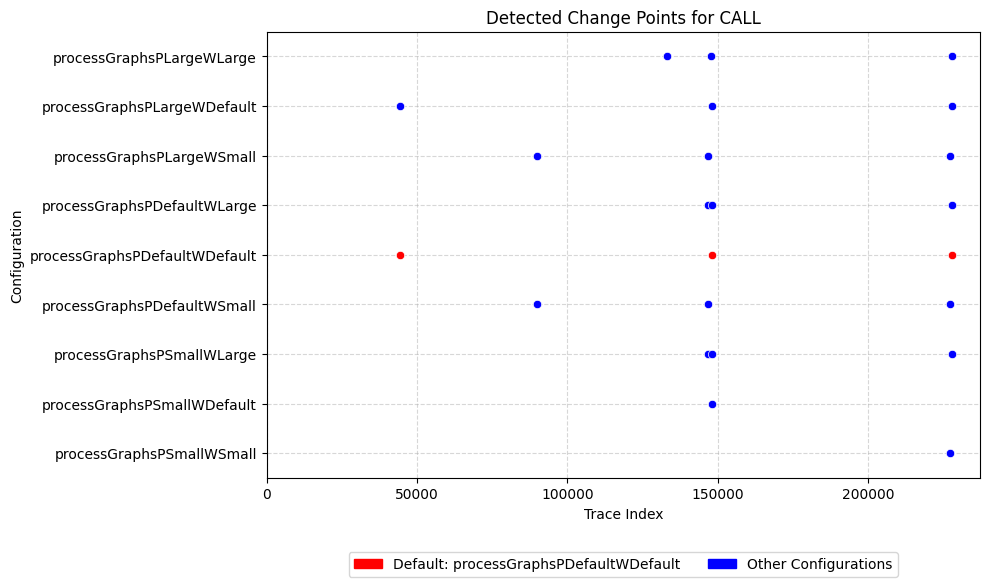

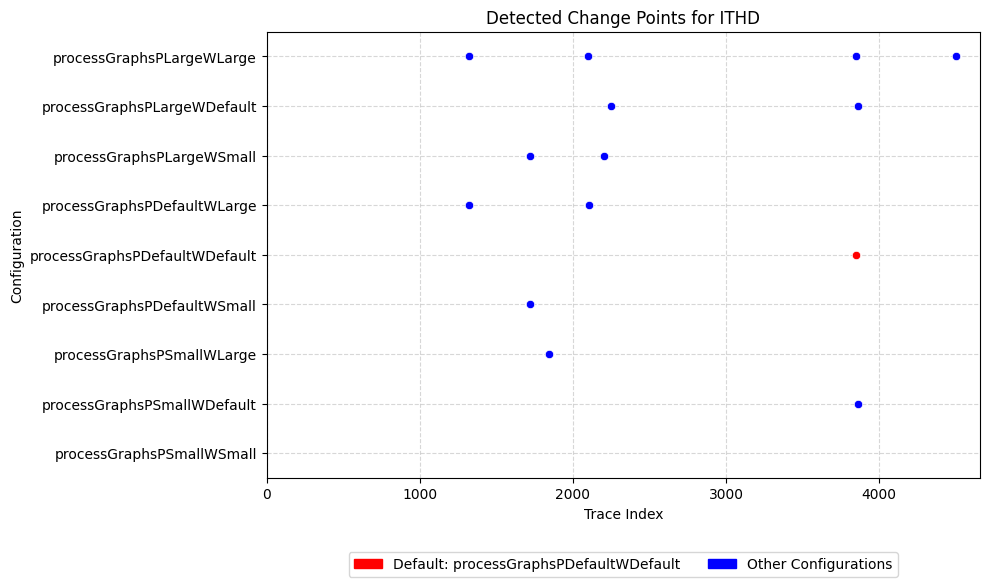

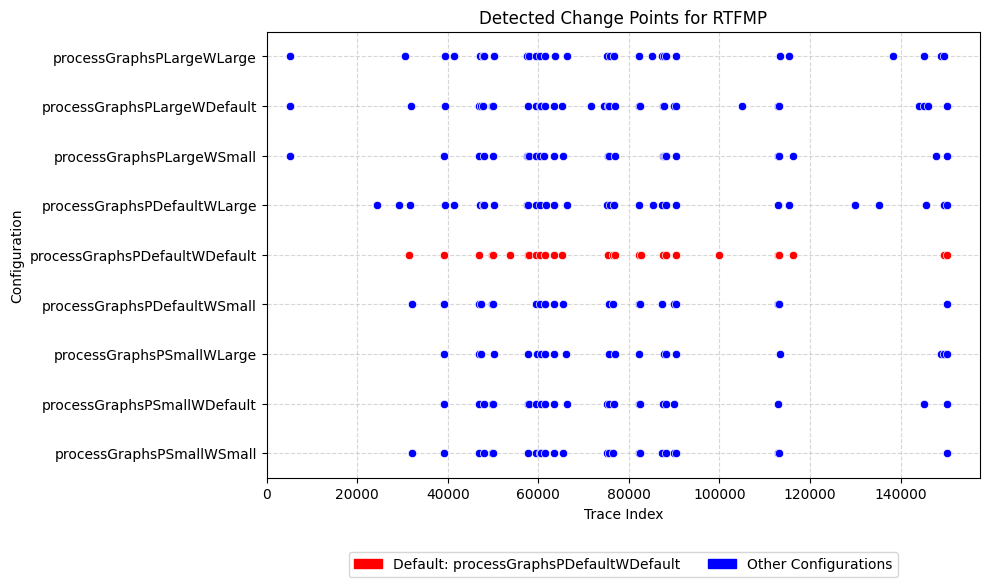

[INFO] No change points to plot for dataset SEPSIS.


In [15]:
# Plot original and deduplicated points
for dataset, df in change_points_dict.items():
    plot_change_points(dataset, change_points_dict[dataset], input_type='list_of_configurations', y_axis_label="Configuration", configuration_labels=parameter_setting_names, default_configuration="processGraphsPDefaultWDefault")

<Figure size 1000x600 with 0 Axes>

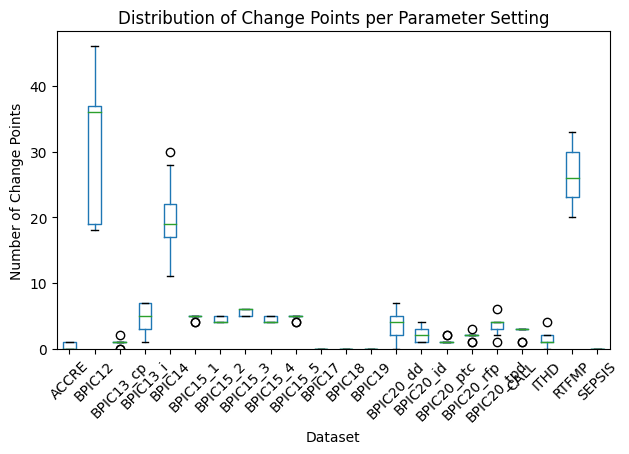

In [16]:
#show boxplot of change point counts per dataset and window setting

# Flatten to a list of (dataset, number of change points per setting entry)
data = []
for dataset, parameter_dict in change_points_dict.items():
    for parameter_setting_name in parameter_setting_names:
        cps = parameter_dict.get(parameter_setting_name, [])
        data.append((dataset, parameter_setting_name, len(cps)))

# Create DataFrame for plotting
df = pd.DataFrame(data, columns=["Dataset", "ParameterSettingsName", "NumChangePoints"])

# Create boxplot
plt.figure(figsize=(10, 6))
df.boxplot(column="NumChangePoints", by="Dataset", grid=False)
plt.title("Distribution of Change Points per Parameter Setting")
plt.suptitle("")  # Remove automatic matplotlib title
plt.xlabel("Dataset")
plt.ylabel("Number of Change Points")
plt.ylim(bottom=0)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



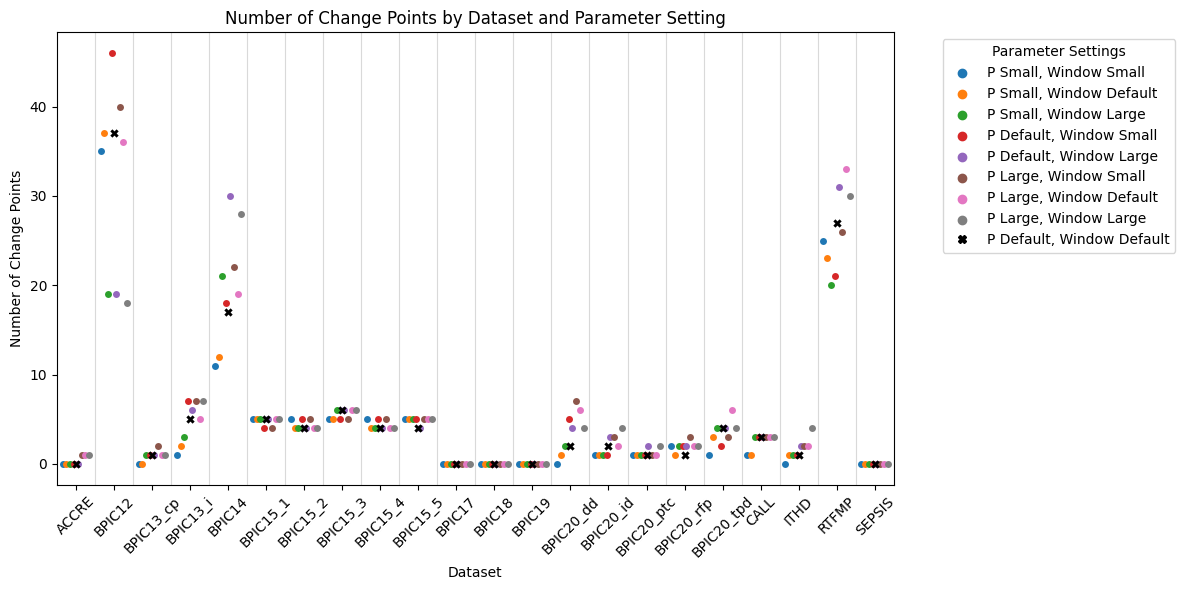

In [17]:
import matplotlib.lines as mlines


# Mapping from parameter_setting_names to readable labels
readable_labels = {
    "processGraphsPSmallWSmall": "P Small, Window Small",
    "processGraphsPSmallWDefault": "P Small, Window Default",
    "processGraphsPSmallWLarge": "P Small, Window Large",
    "processGraphsPDefaultWSmall": "P Default, Window Small",
    "processGraphsPDefaultWDefault": "P Default, Window Default",
    "processGraphsPDefaultWLarge": "P Default, Window Large",
    "processGraphsPLargeWSmall": "P Large, Window Small",
    "processGraphsPLargeWDefault": "P Large, Window Default",
    "processGraphsPLargeWLarge": "P Large, Window Large",
}

# Ensure the mapping is applied cleanly (safe mapping fallback)
df["ReadableLabel"] = df["ParameterSettingsName"].map(readable_labels).fillna("Unmapped")

# Plot
plt.figure(figsize=(12, 6))
order = df['Dataset'].unique()

# Plot all non-default settings
sns.stripplot(
    data=df[df["ParameterSettingsName"] != "processGraphsPDefaultWDefault"],
    x="Dataset",
    y="NumChangePoints",
    hue="ReadableLabel",
    jitter=True,
    dodge=True,
    order=order
)

# Plot default as X marker (no hue, so it won't appear automatically in legend)
default_df = df[df["ParameterSettingsName"] == "processGraphsPDefaultWDefault"]
sns.stripplot(
    data=default_df,
    x="Dataset",
    y="NumChangePoints",
    marker="X",
    color="black",
    jitter=True,
    dodge=True,
    size=6,
    order=order
)

# Get existing legend handles/labels
handles, configuration_labels = plt.gca().get_legend_handles_labels()

# Create manual handle for default setting
default_handle = mlines.Line2D([], [], color='black', marker='X', linestyle='None', markersize=6)
handles.append(default_handle)
configuration_labels.append("P Default, Window Default")

# Apply custom legend
plt.legend(handles, configuration_labels, title="Parameter Settings", bbox_to_anchor=(1.05, 1), loc='upper left')

# Add vertical separators
for i in range(len(order) - 1):
    plt.axvline(i + 0.5, color='0.85', lw=0.8, zorder=0)

plt.title("Number of Change Points by Dataset and Parameter Setting")
plt.xticks(rotation=45)
plt.ylabel("Number of Change Points")
plt.xlabel("Dataset")
plt.tight_layout()
plt.show()


In [18]:
# Summarize relevant change count statistics per dataset
summary_df = df.groupby("Dataset")["NumChangePoints"].agg(
    min_change_points="min",
    max_change_points="max",
    mean_change_points="mean",
    median_change_points="median",
    std_change_points="std",
).reset_index()
summary_df

,Dataset,min_change_points,max_change_points,mean_change_points,median_change_points,std_change_points
0,ACCRE,0,1,0.333333,0.0,0.500000
1,BPIC12,18,46,31.888889,36.0,10.421665
2,BPIC13_cp,0,2,0.888889,1.0,0.600925
3,BPIC13_i,1,7,4.777778,5.0,2.279132
4,BPIC14,11,30,19.777778,19.0,6.398785
5,BPIC15_1,4,5,4.777778,5.0,0.440959
6,BPIC15_2,4,5,4.333333,4.0,0.500000
7,BPIC15_3,5,6,5.555556,6.0,0.527046
8,BPIC15_4,4,5,4.333333,4.0,0.500000
9,BPIC15_5,4,5,4.777778,5.0,0.440959
